## Import

In [31]:
import sys
import os
import tensorflow as tf
import numpy as np
#import tensorflow_probability as tfp

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1)
#tf.random.set_seed(1234)
#tf.enable_eager_execution()
from jupyterthemes import jtplot
jtplot.style(theme="monokai",context="notebook")

In [11]:
import scipy.io
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from datetime import datetime
from pyDOE import lhs
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Prepare data from pendulum dataset (default sample size is 1000)

In [12]:
def prep_data_2d(pendulum):
    NSAMPLE = int(pendulum.size/3)
    th = np.arcsin(pendulum[1])
    thdot = pendulum[2]
    dt = 0.05
    t_total = dt*NSAMPLE
    T = np.linspace(dt,t_total, NSAMPLE)
    
    ##reshape the theta, thdot and t
    th = np.array(th).reshape(1, -1).T
    thdot = np.array(thdot).reshape(1, -1).T
    T = np.array(T).reshape(1, -1).T
    
    X_star = np.hstack((thdot,T))
    u_star = th
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0)
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]
    
    return X_star, u_star, X_u_train, u_train, X_f_train, ub, lb

In [13]:
class Logger(object):
  def __init__(self, frequency=10):
    print("TensorFlow version: {}".format(tf.__version__))
    print("Eager execution: {}".format(tf.executing_eagerly()))
    print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

    self.start_time = time.time()
    self.frequency = frequency

  def __get_elapsed(self):
    return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

  def __get_error_u(self):
    return self.error_fn()

  def set_error_fn(self, error_fn):
    self.error_fn = error_fn
  
  def log_train_start(self, model):
    print("\nTraining started")
    print("================")
    self.model = model
    print(self.model.summary())

  def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
    if epoch % self.frequency == 0:
      print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)

  def log_train_opt(self, name):
    # print(f"tf_epoch =      0  elapsed = 00:00  loss = 2.7391e-01  error = 9.0843e-01")
    print(f"—— Starting {name} optimization ——")

  def log_train_end(self, epoch, custom=""):
    print("==================")
    print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  " + custom)

In [14]:
# Adapted from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py

import tensorflow as tf
import numpy as np
import time

# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
  global global_time_list, global_last_time
  global_time_list = []
  global_last_time = time.perf_counter()
  
def record_time():
  global global_last_time, global_time_list
  new_time = time.perf_counter()
  global_time_list.append(new_time - global_last_time)
  global_last_time = time.perf_counter()
  #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
  """Returns last interval records in millis."""
  global global_last_time, global_time_list
  if global_time_list:
    return 1000 * global_time_list[-1]
  else:
    return 0

def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  if config.maxIter == 0:
    return

  global final_loss, times
  
  maxIter = config.maxIter
  maxEval = config.maxEval or maxIter*1.25
  tolFun = config.tolFun or 1e-5
  tolX = config.tolX or 1e-19
  nCorrection = config.nCorrection or 100
  lineSearch = config.lineSearch
  lineSearchOpts = config.lineSearchOptions
  learningRate = config.learningRate or 1
  isverbose = config.verbose or False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

    # evaluate initial f(x) and df/dx
  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()
    
    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)
      
      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian 
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]
        
      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f
    
    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate


    # optional line search: user function
    lsFuncEval = 0
    if lineSearch and isinstance(lineSearch) == types.FunctionType:
      # perform line search, using user function
      f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
      f_hist.append(f)
    else:
      # no line search, simply move with fixed-step
      x += t*d
      
      if nIter != maxIter:
        # re-evaluate function only if not in last iteration
        # the reason we do this: in a stochastic setting,
        # no use to re-evaluate that function here
        f, g = opfunc(x)
        lsFuncEval = 1
        f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      verbose('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      verbose('optimality condition below tolFun')
      break
    
    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      verbose('step size below tolX')
      break

    if tf.abs(f-f_old) < tolX:
      # function value changing less than tolX
      verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      log_fn(nIter, f.numpy(), True)
      #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
      record_time()
      times.append(last_time())

    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)

## NN parameters

In [15]:
# Data size on the solution u
N_u = 200
# Collocation points size, where we’ll check for f = 0
N_f = 500
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 200
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.99,
  epsilon=1e-1)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 100
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

## Modified PINN for pendulum

In [35]:
class PhysicsInformedNN(object):
  def __init__(self, layers, optimizer, logger, X_f, ub, lb, nu):
    # Descriptive Keras model [2, 20, …, 20, 1]
    self.u_model = tf.keras.Sequential()
    self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.u_model.add(tf.keras.layers.Lambda(
      lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
    for width in layers[1:]:
        self.u_model.add(tf.keras.layers.Dense(
          width, activation=tf.nn.tanh,
          kernel_initializer='glorot_normal'))

    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    self.nu = nu
    self.optimizer = optimizer
    self.logger = logger

    self.dtype = tf.float32

    # Separating the collocation coordinates
    self.thdot_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
    self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)
    
  # Defining custom loss
  def __loss(self, u, u_pred):
    f_pred = self.f_model()
    u_loss = tf.reduce_mean(tf.square(u - u_pred))
    f_loss = tf.reduce_mean(tf.square(f_pred))
    return u_loss, f_loss

  def __grad(self, X, u):
    with tf.GradientTape() as tape:
      u_loss, f_loss = self.__loss(u, self.u_model(X))
      loss_value = u_loss + f_loss
    return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

  def __wrap_training_variables(self):
    var = self.u_model.trainable_variables
    return var

  # The actual PINN
  def f_model(self):
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    with tf.GradientTape(persistent=True) as tape:
      # Watching the two inputs we’ll need later, x and t
      tape.watch(self.thdot_f)
      tape.watch(self.t_f)
      X_f = tf.stack([self.thdot_f[:,0], self.t_f[:,0]], axis=1)

      # Getting the prediction
      u = self.u_model(X_f)
      # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
      u_t = tape.gradient(u, self.t_f)
      print("u_t", u_t)
      u_tt = tape.gradient(u_t,self.t_f)

    # Letting the tape go
    del tape

    nu = self.get_params(numpy=True)

    # Buidling the PINNs
    return u_tt + nu*np.sin(u)

  def get_params(self, numpy=False):
    return self.nu

  def get_weights(self):
    w = []
    for layer in self.u_model.layers[1:]:
      weights_biases = layer.get_weights()
      weights = weights_biases[0].flatten()
      biases = weights_biases[1]
      w.extend(weights)
      w.extend(biases)
    return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):
    for i, layer in enumerate(self.u_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)

  def summary(self):
    return self.u_model.summary()

  # The training function
  def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
    self.logger.log_train_start(self)

    # Creating the tensors
    X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
    u = tf.convert_to_tensor(u, dtype=self.dtype)
    
    fnew = open("loss.txt", "w+")
    fnew.write("u_loss \t \t f_loss \t \t sum_loss \n")

    self.logger.log_train_opt("Adam")
    for epoch in range(tf_epochs):
      # Optimization step
      u_loss, f_loss = self.__loss(u, self.u_model(X_u))
      loss_value, grads = self.__grad(X_u, u)
      fnew.write("%s \t %s \t %s \n" %("{:0.4e}".format(u_loss), "{:0.4e}".format(f_loss), "{:0.4e}".format(loss_value)))
      self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
      self.logger.log_train_epoch(epoch, loss_value)
    
    fnew.close()
    #self.logger.log_train_opt("LBFGS")
    #def loss_and_flat_grad(w):
    #  with tf.GradientTape() as tape:
    #    self.set_weights(w)
    #    loss_value = self.__loss(u, self.u_model(X_u))
    #  grad = tape.gradient(loss_value, self.u_model.trainable_variables)
    #  grad_flat = []
    #  for g in grad:
    #    grad_flat.append(tf.reshape(g, [-1]))
    #  grad_flat =  tf.concat(grad_flat, 0)
    #  return loss_value, grad_flat
    # tfp.optimizer.lbfgs_minimize(
    #   loss_and_flat_grad,
    #   initial_position=self.get_weights(),
    #   num_correction_pairs=nt_config.nCorrection,
    #   max_iterations=nt_config.maxIter,
    #   f_relative_tolerance=nt_config.tolFun,
    #   tolerance=nt_config.tolFun,
    #   parallel_iterations=6)
    #lbfgs(loss_and_flat_grad,
    #  self.get_weights(),
    #  nt_config, Struct(), True,
    #  lambda epoch, loss, is_iter:
    #    self.logger.log_train_epoch(epoch, loss, "", is_iter))

    #self.logger.log_train_end(tf_epochs + nt_config.maxIter)

  def predict(self, X_star):
    u_star = self.u_model(X_star)
    f_star = self.f_model()
    return u_star, f_star

## Load data

In [36]:
pendulum = pd.read_csv('nonaction.txt',delim_whitespace=True,header=None)

In [37]:
X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data_2d(pendulum)

In [38]:
# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, X_f, ub, lb, nu=10/1)
def error():
  u_pred, _ = pinn.predict(X_star)
  return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
logger.set_error_fn(error)
pinn.fit(X_u_train, u_train, tf_epochs, nt_config)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred, f_pred = pinn.predict(X_star)

TensorFlow version: 2.2.0
Eager execution: True
GPU-accerelated: False

Training started
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_19 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_20 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_22 (Dense)             (None, 20)                420       
_______________________________

u_t tf.Tensor(
[[0.00417889]
 [0.0059683 ]
 [0.00727169]
 [0.00777428]
 [0.00351752]
 [0.00351858]
 [0.0064413 ]
 [0.00832589]
 [0.00372789]
 [0.00814201]
 [0.0054915 ]
 [0.00801717]
 [0.00351813]
 [0.00766988]
 [0.00341175]
 [0.00294363]
 [0.00765215]
 [0.0044721 ]
 [0.00559994]
 [0.00399537]
 [0.00469201]
 [0.00630256]
 [0.00351862]
 [0.00854252]
 [0.00778949]
 [0.0080396 ]
 [0.00546108]
 [0.00831228]
 [0.00367118]
 [0.00504256]
 [0.00794783]
 [0.006369  ]
 [0.00701124]
 [0.00517915]
 [0.00287151]
 [0.00803181]
 [0.00270259]
 [0.00232462]
 [0.00673213]
 [0.00285566]
 [0.00675754]
 [0.00702635]
 [0.00259306]
 [0.00483889]
 [0.00840334]
 [0.0085658 ]
 [0.00295048]
 [0.00741143]
 [0.0032775 ]
 [0.00319834]
 [0.00738308]
 [0.00435301]
 [0.00530779]
 [0.00449373]
 [0.00450554]
 [0.0049642 ]
 [0.00635049]
 [0.00663547]
 [0.0033083 ]
 [0.00625927]
 [0.00821357]
 [0.00781223]
 [0.00583021]
 [0.00615188]
 [0.007488  ]
 [0.00449337]
 [0.00661113]
 [0.00822148]
 [0.00451933]
 [0.00679871]
 [0.0

 [0.00782664]], shape=(500, 1), dtype=float32)
u_t tf.Tensor(
[[0.00416427]
 [0.00595108]
 [0.00724972]
 [0.00774964]
 [0.00350478]
 [0.00350396]
 [0.00642108]
 [0.00829688]
 [0.00371461]
 [0.00811419]
 [0.00547837]
 [0.00799168]
 [0.00350588]
 [0.00764375]
 [0.00340108]
 [0.00293052]
 [0.00762927]
 [0.00445867]
 [0.00557863]
 [0.0039838 ]
 [0.00467674]
 [0.0062816 ]
 [0.00350505]
 [0.00851059]
 [0.00776076]
 [0.00801343]
 [0.00544118]
 [0.00828067]
 [0.00365606]
 [0.00502779]
 [0.00792166]
 [0.00634936]
 [0.0069852 ]
 [0.00516512]
 [0.00286013]
 [0.00800142]
 [0.00269055]
 [0.00231484]
 [0.00670847]
 [0.00284412]
 [0.00673805]
 [0.00700185]
 [0.00258206]
 [0.0048249 ]
 [0.00837385]
 [0.00853336]
 [0.00294023]
 [0.00738567]
 [0.00326504]
 [0.00318729]
 [0.00736164]
 [0.00434193]
 [0.00529464]
 [0.00447722]
 [0.00449061]
 [0.00494712]
 [0.00632841]
 [0.00661729]
 [0.00329589]
 [0.00623884]
 [0.00818574]
 [0.00778639]
 [0.0058137 ]
 [0.00613129]
 [0.00746498]
 [0.0044782 ]
 [0.0065861 ]


u_t tf.Tensor(
[[0.00414155]
 [0.00592439]
 [0.00721568]
 [0.00771152]
 [0.00348496]
 [0.0034813 ]
 [0.00638975]
 [0.00825198]
 [0.00369396]
 [0.00807111]
 [0.005458  ]
 [0.00795223]
 [0.00348683]
 [0.0076033 ]
 [0.0033845 ]
 [0.00291016]
 [0.00759382]
 [0.00443782]
 [0.0055456 ]
 [0.00396582]
 [0.00465301]
 [0.00624908]
 [0.00348398]
 [0.00846116]
 [0.00771629]
 [0.00797289]
 [0.00541035]
 [0.00823172]
 [0.00363261]
 [0.00500489]
 [0.00788113]
 [0.00631892]
 [0.00694488]
 [0.00514334]
 [0.00284243]
 [0.00795439]
 [0.00267187]
 [0.00229963]
 [0.00667181]
 [0.00282616]
 [0.00670785]
 [0.00696389]
 [0.00256497]
 [0.00480321]
 [0.00832821]
 [0.00848315]
 [0.00292429]
 [0.0073458 ]
 [0.00324568]
 [0.00317011]
 [0.00732843]
 [0.00432471]
 [0.00527422]
 [0.00445162]
 [0.00446742]
 [0.00492058]
 [0.00629415]
 [0.0065891 ]
 [0.00327665]
 [0.00620713]
 [0.00814267]
 [0.00774638]
 [0.00578813]
 [0.00609934]
 [0.00742932]
 [0.00445461]
 [0.00654735]
 [0.00815079]
 [0.00448812]
 [0.00674131]
 [0.0

u_t tf.Tensor(
[[0.00412719]
 [0.00590755]
 [0.00719423]
 [0.00768752]
 [0.00347243]
 [0.00346699]
 [0.00637003]
 [0.00822372]
 [0.00368092]
 [0.00804401]
 [0.00544515]
 [0.00792741]
 [0.00347478]
 [0.00757785]
 [0.00337402]
 [0.00289731]
 [0.0075715 ]
 [0.00442465]
 [0.00552479]
 [0.00395447]
 [0.00463803]
 [0.00622858]
 [0.0034707 ]
 [0.00843005]
 [0.00768831]
 [0.00794737]
 [0.00539092]
 [0.00820093]
 [0.00361781]
 [0.00499045]
 [0.0078556 ]
 [0.00629972]
 [0.00691949]
 [0.00512959]
 [0.00283124]
 [0.00792479]
 [0.00266008]
 [0.00229   ]
 [0.00664874]
 [0.0028148 ]
 [0.00668881]
 [0.00693997]
 [0.00255415]
 [0.00478953]
 [0.00829948]
 [0.00845155]
 [0.00291421]
 [0.0073207 ]
 [0.00323343]
 [0.00315925]
 [0.0073075 ]
 [0.00431383]
 [0.00526134]
 [0.00443549]
 [0.00445277]
 [0.00490383]
 [0.00627254]
 [0.00657134]
 [0.00326451]
 [0.00618713]
 [0.00811556]
 [0.00772119]
 [0.00577202]
 [0.00607918]
 [0.00740687]
 [0.00443972]
 [0.00652294]
 [0.00812376]
 [0.00447612]
 [0.00671935]
 [0.0

u_t tf.Tensor(
[[0.00407233]
 [0.00584341]
 [0.00711263]
 [0.00759645]
 [0.0034245 ]
 [0.00341249]
 [0.00629508]
 [0.00811647]
 [0.00363103]
 [0.00794113]
 [0.00539614]
 [0.00783321]
 [0.00342868]
 [0.0074812 ]
 [0.00333392]
 [0.00284831]
 [0.00748666]
 [0.00437437]
 [0.00544565]
 [0.00391105]
 [0.00458077]
 [0.00615049]
 [0.00342007]
 [0.00831196]
 [0.00758207]
 [0.00785038]
 [0.00531703]
 [0.00808405]
 [0.00356143]
 [0.00493554]
 [0.0077586 ]
 [0.00622662]
 [0.00682307]
 [0.00507716]
 [0.00278836]
 [0.00781242]
 [0.00261512]
 [0.00225311]
 [0.00656109]
 [0.00277132]
 [0.00661639]
 [0.00684893]
 [0.00251273]
 [0.00473751]
 [0.00819044]
 [0.00833163]
 [0.00287563]
 [0.00722537]
 [0.00318654]
 [0.0031177 ]
 [0.00722792]
 [0.00427227]
 [0.0052122 ]
 [0.00437407]
 [0.00439677]
 [0.00483983]
 [0.00619019]
 [0.00650374]
 [0.00321824]
 [0.00611088]
 [0.00801267]
 [0.00762549]
 [0.00571078]
 [0.00600232]
 [0.00732153]
 [0.00438277]
 [0.0064302 ]
 [0.00802118]
 [0.00443031]
 [0.00663595]
 [0.0

tf_epoch =     10  elapsed = 00:00  loss = 4.6858e+00  error = 1.0189e+00  
u_t tf.Tensor(
[[0.00405016]
 [0.00581756]
 [0.00707981]
 [0.00755992]
 [0.00340511]
 [0.00339053]
 [0.00626497]
 [0.00807344]
 [0.00361084]
 [0.00789987]
 [0.00537637]
 [0.00779543]
 [0.00341001]
 [0.00744242]
 [0.00331769]
 [0.00282854]
 [0.00745257]
 [0.00435405]
 [0.00541383]
 [0.0038935 ]
 [0.00455762]
 [0.00611904]
 [0.00339968]
 [0.00826458]
 [0.00753945]
 [0.00781143]
 [0.00528733]
 [0.00803716]
 [0.0035387 ]
 [0.00491346]
 [0.00771963]
 [0.00619719]
 [0.00678437]
 [0.005056  ]
 [0.00277098]
 [0.00776734]
 [0.00259699]
 [0.00223815]
 [0.0065259 ]
 [0.0027537 ]
 [0.00658725]
 [0.00681231]
 [0.00249594]
 [0.00471657]
 [0.0081467 ]
 [0.00828352]
 [0.00286001]
 [0.00718711]
 [0.00316754]
 [0.00310087]
 [0.00719593]
 [0.00425548]
 [0.00519238]
 [0.00434935]
 [0.00437413]
 [0.00481398]
 [0.006157  ]
 [0.00647653]
 [0.0031996 ]
 [0.00608013]
 [0.00797139]
 [0.00758705]
 [0.00568617]
 [0.00597134]
 [0.00728724]

u_t tf.Tensor(
[[0.00397211]
 [0.00572701]
 [0.00696503]
 [0.0074326 ]
 [0.00333678]
 [0.00331354]
 [0.00615988]
 [0.00792347]
 [0.00353976]
 [0.00775605]
 [0.00530704]
 [0.00766378]
 [0.00334416]
 [0.00730721]
 [0.0032605 ]
 [0.00275918]
 [0.00733348]
 [0.00428262]
 [0.00530261]
 [0.00383171]
 [0.00447616]
 [0.0060089 ]
 [0.0033282 ]
 [0.00809941]
 [0.00739089]
 [0.00767547]
 [0.00518353]
 [0.00787375]
 [0.00345905]
 [0.00483623]
 [0.00758353]
 [0.00609416]
 [0.00664934]
 [0.00498173]
 [0.00270964]
 [0.00761019]
 [0.00253338]
 [0.0021853 ]
 [0.00640312]
 [0.00269153]
 [0.00648535]
 [0.00668422]
 [0.00243668]
 [0.00464336]
 [0.00799423]
 [0.00811583]
 [0.00280493]
 [0.00705365]
 [0.00310055]
 [0.00304158]
 [0.00708413]
 [0.00419641]
 [0.00512282]
 [0.00426284]
 [0.00429441]
 [0.00472306]
 [0.00604066]
 [0.00638137]
 [0.00313423]
 [0.00597233]
 [0.00782755]
 [0.00745291]
 [0.00560021]
 [0.00586263]
 [0.00716751]
 [0.00427867]
 [0.00626292]
 [0.00783661]
 [0.00434674]
 [0.00648565]
 [0.0

u_t tf.Tensor(
[[0.0039423 ]
 [0.00569257]
 [0.00692147]
 [0.00738446]
 [0.00331064]
 [0.00328424]
 [0.00612007]
 [0.00786676]
 [0.00351257]
 [0.00770166]
 [0.00528065]
 [0.007614  ]
 [0.00331894]
 [0.00725606]
 [0.00323863]
 [0.00273275]
 [0.00728834]
 [0.00425536]
 [0.00526042]
 [0.0038081 ]
 [0.00444503]
 [0.00596703]
 [0.00330101]
 [0.00803693]
 [0.00733469]
 [0.00762396]
 [0.00514415]
 [0.00781196]
 [0.00342874]
 [0.00480693]
 [0.00753195]
 [0.00605501]
 [0.00659823]
 [0.00495343]
 [0.00268612]
 [0.00755074]
 [0.00250915]
 [0.00216502]
 [0.00635662]
 [0.00266771]
 [0.00644667]
 [0.00663559]
 [0.00241397]
 [0.00461557]
 [0.00793657]
 [0.00805241]
 [0.00278383]
 [0.00700313]
 [0.00307489]
 [0.00301888]
 [0.00704173]
 [0.00417386]
 [0.00509632]
 [0.00422998]
 [0.00426393]
 [0.00468835]
 [0.00599639]
 [0.00634524]
 [0.00310936]
 [0.00593128]
 [0.00777315]
 [0.0074021 ]
 [0.00556763]
 [0.00582123]
 [0.00712213]
 [0.00424768]
 [0.00621365]
 [0.00778238]
 [0.00432192]
 [0.00644143]
 [0.0

 [0.0073066 ]], shape=(500, 1), dtype=float32)
u_t tf.Tensor(
[[0.00384159]
 [0.00557686]
 [0.00677547]
 [0.00722374]
 [0.00322222]
 [0.00318577]
 [0.00598691]
 [0.00767743]
 [0.00342066]
 [0.00752013]
 [0.00519184]
 [0.0074479 ]
 [0.00323349]
 [0.00708521]
 [0.00316462]
 [0.00264379]
 [0.00713725]
 [0.00416337]
 [0.0051191 ]
 [0.00372834]
 [0.00433989]
 [0.00582644]
 [0.00320966]
 [0.00782831]
 [0.00714708]
 [0.0074517 ]
 [0.0050123 ]
 [0.00760569]
 [0.00332685]
 [0.00470871]
 [0.00735938]
 [0.0059236 ]
 [0.00642742]
 [0.00485813]
 [0.00260638]
 [0.00735228]
 [0.00242764]
 [0.0020962 ]
 [0.00620125]
 [0.00258698]
 [0.00631699]
 [0.00647258]
 [0.00233697]
 [0.00452238]
 [0.00774407]
 [0.0078407 ]
 [0.00271242]
 [0.00683435]
 [0.00298796]
 [0.00294207]
 [0.0068997 ]
 [0.00409773]
 [0.00500713]
 [0.00411978]
 [0.00416094]
 [0.00457123]
 [0.00584757]
 [0.00622409]
 [0.00302577]
 [0.00579322]
 [0.00759157]
 [0.00723222]
 [0.00545858]
 [0.00568195]
 [0.00697032]
 [0.00414296]
 [0.00604889]


u_t tf.Tensor(
[[0.00368146]
 [0.00539471]
 [0.00654665]
 [0.00697387]
 [0.00308124]
 [0.00303061]
 [0.00577903]
 [0.00738304]
 [0.00327426]
 [0.00723795]
 [0.0050517 ]
 [0.00718977]
 [0.00309686]
 [0.00681929]
 [0.00304661]
 [0.00250319]
 [0.00690112]
 [0.00401744]
 [0.00489788]
 [0.0036015 ]
 [0.00417263]
 [0.00560535]
 [0.00306582]
 [0.00750381]
 [0.00685528]
 [0.0071829 ]
 [0.00480598]
 [0.00728502]
 [0.00316625]
 [0.00455485]
 [0.00708984]
 [0.00571714]
 [0.00616128]
 [0.00470749]
 [0.00247863]
 [0.00704356]
 [0.00229894]
 [0.00198572]
 [0.00595907]
 [0.00245782]
 [0.00611374]
 [0.00621701]
 [0.00221365]
 [0.0043763 ]
 [0.00744473]
 [0.00751151]
 [0.00259834]
 [0.0065714 ]
 [0.00284895]
 [0.00281951]
 [0.00667742]
 [0.00397683]
 [0.00486622]
 [0.0039468 ]
 [0.00399697]
 [0.00438529]
 [0.00561304]
 [0.0060341 ]
 [0.00289406]
 [0.00557539]
 [0.00730929]
 [0.00696724]
 [0.00528821]
 [0.00546207]
 [0.00673325]
 [0.00397623]
 [0.00579171]
 [0.0073199 ]
 [0.00410525]
 [0.00606341]
 [0.0

u_t tf.Tensor(
[[0.00363691]
 [0.0053444 ]
 [0.00648364]
 [0.00690548]
 [0.00304193]
 [0.00298771]
 [0.00572196]
 [0.00730248]
 [0.00323346]
 [0.00716073]
 [0.00501292]
 [0.00711915]
 [0.00305867]
 [0.00674646]
 [0.0030137 ]
 [0.00246422]
 [0.00683623]
 [0.0039769 ]
 [0.00483702]
 [0.00356619]
 [0.00412606]
 [0.00554434]
 [0.00302608]
 [0.00741497]
 [0.0067754 ]
 [0.00710913]
 [0.00474924]
 [0.00719725]
 [0.00312184]
 [0.0045125 ]
 [0.00701582]
 [0.0056602 ]
 [0.00608833]
 [0.00466575]
 [0.00244288]
 [0.00695904]
 [0.00226332]
 [0.00195475]
 [0.00589266]
 [0.00242171]
 [0.00605778]
 [0.00614664]
 [0.00217915]
 [0.00433607]
 [0.00736279]
 [0.00742141]
 [0.00256649]
 [0.00649932]
 [0.00281009]
 [0.00278532]
 [0.00661628]
 [0.00394322]
 [0.0048272 ]
 [0.00389913]
 [0.00395129]
 [0.00433361]
 [0.0055482 ]
 [0.00598177]
 [0.00285765]
 [0.0055151 ]
 [0.00723204]
 [0.00689455]
 [0.00524141]
 [0.0054012 ]
 [0.00666816]
 [0.00392978]
 [0.00572112]
 [0.00724287]
 [0.00406833]
 [0.00600029]
 [0.0

u_t tf.Tensor(
[[0.00349264]
 [0.00518253]
 [0.00628145]
 [0.00668716]
 [0.00291442]
 [0.00284955]
 [0.00553924]
 [0.0070453 ]
 [0.00310122]
 [0.00691429]
 [0.00488795]
 [0.00689379]
 [0.00293449]
 [0.00651376]
 [0.00290695]
 [0.0023385 ]
 [0.0066284 ]
 [0.00384581]
 [0.00464188]
 [0.00345185]
 [0.00397517]
 [0.00534815]
 [0.00289817]
 [0.00713129]
 [0.00652037]
 [0.00687308]
 [0.00456738]
 [0.00691714]
 [0.00297879]
 [0.00437664]
 [0.00677883]
 [0.00547722]
 [0.00585513]
 [0.00453109]
 [0.00232652]
 [0.00668915]
 [0.00214844]
 [0.00185379]
 [0.00568036]
 [0.0023043 ]
 [0.00587823]
 [0.00592081]
 [0.00206694]
 [0.00420694]
 [0.00710124]
 [0.00713378]
 [0.00246307]
 [0.0062689 ]
 [0.00268382]
 [0.00267434]
 [0.00642025]
 [0.00383447]
 [0.00470137]
 [0.00374599]
 [0.00380319]
 [0.00416641]
 [0.00533942]
 [0.00581381]
 [0.00274042]
 [0.00532081]
 [0.00698549]
 [0.00666205]
 [0.00509153]
 [0.00520496]
 [0.00645981]
 [0.00377923]
 [0.00549519]
 [0.00699705]
 [0.00394896]
 [0.00579854]
 [0.0

u_t tf.Tensor(
[[0.00344109]
 [0.00512505]
 [0.00620983]
 [0.00661022]
 [0.00286878]
 [0.00280044]
 [0.00547466]
 [0.00695468]
 [0.0030539 ]
 [0.00682747]
 [0.0048435 ]
 [0.00681441]
 [0.00288992]
 [0.0064317 ]
 [0.00286873]
 [0.00229371]
 [0.00655492]
 [0.00379902]
 [0.00457282]
 [0.00341098]
 [0.0039212 ]
 [0.00527853]
 [0.00285273]
 [0.00703131]
 [0.0064305 ]
 [0.00678972]
 [0.00450303]
 [0.00681844]
 [0.00292793]
 [0.00432853]
 [0.00669508]
 [0.00541232]
 [0.00577284]
 [0.00448315]
 [0.00228472]
 [0.00659403]
 [0.00210755]
 [0.00181746]
 [0.00560543]
 [0.00226217]
 [0.00581464]
 [0.00584083]
 [0.00202666]
 [0.0041612 ]
 [0.00700908]
 [0.00703244]
 [0.002426  ]
 [0.0061876 ]
 [0.00263853]
 [0.0026346 ]
 [0.00635088]
 [0.00379564]
 [0.00465658]
 [0.0036917 ]
 [0.0037502 ]
 [0.0041067 ]
 [0.00526522]
 [0.00575432]
 [0.00269876]
 [0.00525169]
 [0.00689863]
 [0.00657997]
 [0.00503854]
 [0.00513514]
 [0.0063862 ]
 [0.00372536]
 [0.00541538]
 [0.00691044]
 [0.00390637]
 [0.00572736]
 [0.0

u_t tf.Tensor(
[[0.00327634]
 [0.00494256]
 [0.00598301]
 [0.00636788]
 [0.00272265]
 [0.00264432]
 [0.00527059]
 [0.00666933]
 [0.00290251]
 [0.00655412]
 [0.00470215]
 [0.00656447]
 [0.00274684]
 [0.00617302]
 [0.00274637]
 [0.00215103]
 [0.00632265]
 [0.00364972]
 [0.00435425]
 [0.00328036]
 [0.00374857]
 [0.00505765]
 [0.00270837]
 [0.00671637]
 [0.0061474 ]
 [0.00652651]
 [0.00429948]
 [0.00650765]
 [0.0027662 ]
 [0.00417622]
 [0.0064305 ]
 [0.00520655]
 [0.00551333]
 [0.0043305 ]
 [0.0021504 ]
 [0.00629434]
 [0.00197745]
 [0.00170051]
 [0.00536907]
 [0.00212697]
 [0.00561335]
 [0.00558758]
 [0.00189731]
 [0.00401628]
 [0.00671882]
 [0.00671329]
 [0.00230721]
 [0.00593109]
 [0.00249318]
 [0.00250727]
 [0.00613139]
 [0.00367163]
 [0.00451406]
 [0.00351961]
 [0.00358058]
 [0.00391606]
 [0.00502943]
 [0.0055659 ]
 [0.00256634]
 [0.00503181]
 [0.00662514]
 [0.00632097]
 [0.00487112]
 [0.00491295]
 [0.00615374]
 [0.00355298]
 [0.00516332]
 [0.00663774]
 [0.00377043]
 [0.00550285]
 [0.0

u_t tf.Tensor(
[[0.00321815]
 [0.00487852]
 [0.0059036 ]
 [0.00628349]
 [0.00267095]
 [0.00258945]
 [0.00519929]
 [0.00657   ]
 [0.00284898]
 [0.00645897]
 [0.00465246]
 [0.00647747]
 [0.00269607]
 [0.00608286]
 [0.00270307]
 [0.00210077]
 [0.00624148]
 [0.00359705]
 [0.00427778]
 [0.00323421]
 [0.00368753]
 [0.00498018]
 [0.00265767]
 [0.00660669]
 [0.00604881]
 [0.00643465]
 [0.0042283 ]
 [0.00639945]
 [0.00270935]
 [0.00412291]
 [0.0063381 ]
 [0.00513444]
 [0.00542284]
 [0.00427679]
 [0.0021027 ]
 [0.00618995]
 [0.00193168]
 [0.0016589 ]
 [0.00528663]
 [0.00207902]
 [0.0055429 ]
 [0.00549895]
 [0.00185141]
 [0.00396554]
 [0.00661776]
 [0.00660218]
 [0.00226513]
 [0.00584164]
 [0.00244163]
 [0.00246221]
 [0.00605462]
 [0.00362786]
 [0.00446392]
 [0.0034593 ]
 [0.00352058]
 [0.00384876]
 [0.00494661]
 [0.00549995]
 [0.00251982]
 [0.00495449]
 [0.00652994]
 [0.00623062]
 [0.00481263]
 [0.0048348 ]
 [0.00607259]
 [0.003492  ]
 [0.0050753 ]
 [0.00654281]
 [0.00372248]
 [0.00542458]
 [0.0

u_t tf.Tensor(
[[0.0030342 ]
 [0.00467736]
 [0.00565472]
 [0.00602041]
 [0.00250723]
 [0.00241686]
 [0.00497627]
 [0.00626046]
 [0.00267955]
 [0.00616255]
 [0.00449612]
 [0.00620639]
 [0.00253474]
 [0.00580156]
 [0.00256594]
 [0.0019423 ]
 [0.00598761]
 [0.00343079]
 [0.00403831]
 [0.00308827]
 [0.00349429]
 [0.00473703]
 [0.0024983 ]
 [0.00626485]
 [0.00574155]
 [0.00614766]
 [0.00400547]
 [0.00606228]
 [0.00253043]
 [0.00395589]
 [0.00604925]
 [0.00490819]
 [0.00514042]
 [0.00410759]
 [0.00195103]
 [0.00586452]
 [0.00178755]
 [0.00152631]
 [0.00502932]
 [0.0019268 ]
 [0.00532227]
 [0.00522129]
 [0.00170562]
 [0.00380647]
 [0.00630283]
 [0.00625594]
 [0.00213173]
 [0.00556231]
 [0.00227801]
 [0.0023194 ]
 [0.00581422]
 [0.00348958]
 [0.00430607]
 [0.00327011]
 [0.00333052]
 [0.00363615]
 [0.00468621]
 [0.0052933 ]
 [0.00237349]
 [0.00471108]
 [0.00623333]
 [0.00594853]
 [0.00462972]
 [0.00458875]
 [0.00581904]
 [0.00329892]
 [0.00480024]
 [0.00624705]
 [0.0035711 ]
 [0.00518029]
 [0.0

u_t tf.Tensor(
[[0.00296987]
 [0.00460745]
 [0.0055684 ]
 [0.00592964]
 [0.00244988]
 [0.00235678]
 [0.00489905]
 [0.00615373]
 [0.00262024]
 [0.00606035]
 [0.0044417 ]
 [0.00611292]
 [0.00247803]
 [0.00570443]
 [0.00251789]
 [0.001887  ]
 [0.00589974]
 [0.00337271]
 [0.00395531]
 [0.00303722]
 [0.0034266 ]
 [0.00465258]
 [0.00244286]
 [0.00614693]
 [0.00563557]
 [0.00604845]
 [0.00392828]
 [0.00594602]
 [0.00246811]
 [0.00389798]
 [0.00594934]
 [0.00482966]
 [0.00504288]
 [0.00404863]
 [0.00189769]
 [0.00575224]
 [0.00173733]
 [0.00147957]
 [0.00494043]
 [0.00187335]
 [0.0052458 ]
 [0.00512505]
 [0.0016544 ]
 [0.00375128]
 [0.00619422]
 [0.00613653]
 [0.00208494]
 [0.00546579]
 [0.00222055]
 [0.00226936]
 [0.00573092]
 [0.00344125]
 [0.00425109]
 [0.00320443]
 [0.00326391]
 [0.00356184]
 [0.00459563]
 [0.00522166]
 [0.00232257]
 [0.00462629]
 [0.00613107]
 [0.00585108]
 [0.00456642]
 [0.00450304]
 [0.00573138]
 [0.00323128]
 [0.0047051 ]
 [0.00614507]
 [0.00351823]
 [0.00509593]
 [0.0

u_t tf.Tensor(
[[0.00283692]
 [0.00446364]
 [0.00539108]
 [0.0057439 ]
 [0.0023312 ]
 [0.00223301]
 [0.0047406 ]
 [0.00593545]
 [0.00249754]
 [0.00585137]
 [0.00432961]
 [0.00592172]
 [0.00236036]
 [0.00550554]
 [0.00241846]
 [0.00177287]
 [0.00571949]
 [0.0032528 ]
 [0.0037849 ]
 [0.00293168]
 [0.00328653]
 [0.00447895]
 [0.00232873]
 [0.00590571]
 [0.00541875]
 [0.00584514]
 [0.00376986]
 [0.00570819]
 [0.00233971]
 [0.00377905]
 [0.0057445 ]
 [0.00466826]
 [0.00484313]
 [0.00392708]
 [0.00178696]
 [0.00552249]
 [0.0016338 ]
 [0.00138239]
 [0.00475838]
 [0.00176255]
 [0.00508883]
 [0.00492745]
 [0.00154819]
 [0.00363791]
 [0.00597206]
 [0.00589233]
 [0.00198806]
 [0.00526803]
 [0.00210143]
 [0.00216575]
 [0.00555992]
 [0.0033414 ]
 [0.00413777]
 [0.00306943]
 [0.00312604]
 [0.0034083 ]
 [0.00440915]
 [0.00507455]
 [0.0022177 ]
 [0.00445158]
 [0.00592193]
 [0.00565147]
 [0.0044366 ]
 [0.00432638]
 [0.00555173]
 [0.00309129]
 [0.00451005]
 [0.00593653]
 [0.00340906]
 [0.00492317]
 [0.0

u_t tf.Tensor(
[[0.00276839]
 [0.00438984]
 [0.0053002 ]
 [0.00564906]
 [0.00226995]
 [0.0021694 ]
 [0.00465947]
 [0.00582406]
 [0.00243424]
 [0.00574473]
 [0.00427201]
 [0.00582414]
 [0.00229945]
 [0.00540393]
 [0.00236712]
 [0.00171411]
 [0.00562724]
 [0.00319105]
 [0.00369761]
 [0.00287726]
 [0.00321423]
 [0.00438989]
 [0.0022701 ]
 [0.00578259]
 [0.00530809]
 [0.00574119]
 [0.00368874]
 [0.00558683]
 [0.0022737 ]
 [0.0037181 ]
 [0.00563972]
 [0.00458551]
 [0.00474107]
 [0.00386458]
 [0.00172964]
 [0.00540519]
 [0.00158057]
 [0.00133198]
 [0.00466534]
 [0.00170526]
 [0.00500843]
 [0.00482624]
 [0.00149326]
 [0.0035798 ]
 [0.00585868]
 [0.00576771]
 [0.00193802]
 [0.00516694]
 [0.00203984]
 [0.00211226]
 [0.00547234]
 [0.00328994]
 [0.00407952]
 [0.0030002 ]
 [0.00305484]
 [0.00332916]
 [0.00431338]
 [0.00499919]
 [0.00216382]
 [0.00436176]
 [0.00581522]
 [0.00554947]
 [0.00437017]
 [0.00423555]
 [0.00545989]
 [0.00301901]
 [0.00441028]
 [0.00583012]
 [0.00335282]
 [0.00483492]
 [0.0

u_t tf.Tensor(
[[0.00255509]
 [0.00416145]
 [0.00501944]
 [0.00535749]
 [0.00207904]
 [0.00197219]
 [0.00440907]
 [0.00548193]
 [0.00223704]
 [0.00541726]
 [0.0040935 ]
 [0.00552431]
 [0.00210883]
 [0.00509124]
 [0.00220709]
 [0.00153147]
 [0.0053428 ]
 [0.00299904]
 [0.00342808]
 [0.00270782]
 [0.00298872]
 [0.00411448]
 [0.00208848]
 [0.0054043 ]
 [0.00496805]
 [0.00542111]
 [0.00343841]
 [0.00521395]
 [0.0020689 ]
 [0.00352988]
 [0.00531689]
 [0.00432975]
 [0.00442704]
 [0.00367066]
 [0.00155019]
 [0.00504461]
 [0.00141539]
 [0.00117378]
 [0.00437905]
 [0.0015263 ]
 [0.00476032]
 [0.00451384]
 [0.00132156]
 [0.0034002 ]
 [0.00551033]
 [0.00538488]
 [0.00178188]
 [0.00485561]
 [0.00184736]
 [0.00194545]
 [0.00520201]
 [0.00312985]
 [0.00389886]
 [0.00278613]
 [0.00283271]
 [0.00308295]
 [0.00401675]
 [0.00476655]
 [0.00199681]
 [0.00408315]
 [0.00548749]
 [0.0052356 ]
 [0.00416539]
 [0.00395382]
 [0.00517708]
 [0.00279359]
 [0.00410284]
 [0.00550331]
 [0.00317799]
 [0.00456339]
 [0.0

u_t tf.Tensor(
[[0.00255509]
 [0.00416145]
 [0.00501944]
 [0.00535749]
 [0.00207904]
 [0.00197219]
 [0.00440907]
 [0.00548193]
 [0.00223704]
 [0.00541726]
 [0.0040935 ]
 [0.00552431]
 [0.00210883]
 [0.00509124]
 [0.00220709]
 [0.00153147]
 [0.0053428 ]
 [0.00299904]
 [0.00342808]
 [0.00270782]
 [0.00298872]
 [0.00411448]
 [0.00208848]
 [0.0054043 ]
 [0.00496805]
 [0.00542111]
 [0.00343841]
 [0.00521395]
 [0.0020689 ]
 [0.00352988]
 [0.00531689]
 [0.00432975]
 [0.00442704]
 [0.00367066]
 [0.00155019]
 [0.00504461]
 [0.00141539]
 [0.00117378]
 [0.00437905]
 [0.0015263 ]
 [0.00476032]
 [0.00451384]
 [0.00132156]
 [0.0034002 ]
 [0.00551033]
 [0.00538488]
 [0.00178188]
 [0.00485561]
 [0.00184736]
 [0.00194545]
 [0.00520201]
 [0.00312985]
 [0.00389886]
 [0.00278613]
 [0.00283271]
 [0.00308295]
 [0.00401675]
 [0.00476655]
 [0.00199681]
 [0.00408315]
 [0.00548749]
 [0.0052356 ]
 [0.00416539]
 [0.00395382]
 [0.00517708]
 [0.00279359]
 [0.00410284]
 [0.00550331]
 [0.00317799]
 [0.00456339]
 [0.0

u_t tf.Tensor(
[[0.00225463]
 [0.00384274]
 [0.00462853]
 [0.00495469]
 [0.00180946]
 [0.00169599]
 [0.00406076]
 [0.00501029]
 [0.00195879]
 [0.00496593]
 [0.00384371]
 [0.0051106 ]
 [0.00183762]
 [0.00465863]
 [0.00198094]
 [0.00127454]
 [0.00494807]
 [0.00272901]
 [0.00305317]
 [0.00246893]
 [0.00266978]
 [0.00373058]
 [0.00183445]
 [0.00488245]
 [0.00449898]
 [0.00497793]
 [0.00309058]
 [0.00469969]
 [0.00178178]
 [0.00326792]
 [0.00486946]
 [0.00397352]
 [0.0039928 ]
 [0.00339887]
 [0.00129491]
 [0.00454679]
 [0.00118384]
 [0.00094763]
 [0.0039831 ]
 [0.00127263]
 [0.00441559]
 [0.00407969]
 [0.00107802]
 [0.00315001]
 [0.00502986]
 [0.00485703]
 [0.00156101]
 [0.00442433]
 [0.00157437]
 [0.00170968]
 [0.00482615]
 [0.00290439]
 [0.00364579]
 [0.00248768]
 [0.00251834]
 [0.00273617]
 [0.00360216]
 [0.00444318]
 [0.00176305]
 [0.00369268]
 [0.00503578]
 [0.00480159]
 [0.00388129]
 [0.00355898]
 [0.0047856 ]
 [0.0024748 ]
 [0.00367658]
 [0.00505285]
 [0.00293206]
 [0.00418802]
 [0.0

u_t tf.Tensor(
[[0.00217701]
 [0.0037609 ]
 [0.00452829]
 [0.00485192]
 [0.00173971]
 [0.00162489]
 [0.00397144]
 [0.00489017]
 [0.00188683]
 [0.00485099]
 [0.00377946]
 [0.00500513]
 [0.00176706]
 [0.00454814]
 [0.00192239]
 [0.0012082 ]
 [0.00484708]
 [0.00265931]
 [0.00295709]
 [0.00240716]
 [0.00258712]
 [0.00363208]
 [0.00176912]
 [0.00474948]
 [0.00437944]
 [0.00486472]
 [0.00300151]
 [0.00456866]
 [0.0017078 ]
 [0.00320075]
 [0.0047551 ]
 [0.00388218]
 [0.00388197]
 [0.00332887]
 [0.00122851]
 [0.00441985]
 [0.0011242 ]
 [0.0008886 ]
 [0.00388203]
 [0.00120684]
 [0.00432733]
 [0.00396852]
 [0.00101482]
 [0.00308582]
 [0.00490743]
 [0.00472256]
 [0.0015038 ]
 [0.00431408]
 [0.00150351]
 [0.00164863]
 [0.00472985]
 [0.00284614]
 [0.00358064]
 [0.00241108]
 [0.00243684]
 [0.00264658]
 [0.0034956 ]
 [0.00436035]
 [0.00170289]
 [0.00359212]
 [0.00492075]
 [0.00469083]
 [0.00380862]
 [0.0034573 ]
 [0.00468563]
 [0.0023922 ]
 [0.00356757]
 [0.00493814]
 [0.00286857]
 [0.00409223]
 [0.0

u_t tf.Tensor(
[[0.00193907]
 [0.00351114]
 [0.00422258]
 [0.00453964]
 [0.00152565]
 [0.00140747]
 [0.00369894]
 [0.00452581]
 [0.00166607]
 [0.0045024 ]
 [0.00358306]
 [0.0046849 ]
 [0.00154951]
 [0.00421215]
 [0.00174262]
 [0.00100482]
 [0.0045396 ]
 [0.00244579]
 [0.00266425]
 [0.0022177 ]
 [0.00233305]
 [0.00333166]
 [0.00156947]
 [0.00434597]
 [0.00401672]
 [0.00452054]
 [0.00273019]
 [0.00417104]
 [0.0014814 ]
 [0.00299597]
 [0.00440721]
 [0.00360367]
 [0.00354522]
 [0.00311478]
 [0.0010239 ]
 [0.00403441]
 [0.00094179]
 [0.00070614]
 [0.00357489]
 [0.00100455]
 [0.00405857]
 [0.00362998]
 [0.00082045]
 [0.00289003]
 [0.0045359 ]
 [0.00431462]
 [0.00132803]
 [0.00397857]
 [0.00128555]
 [0.00146121]
 [0.0044364 ]
 [0.00266755]
 [0.00338142]
 [0.00217737]
 [0.00218627]
 [0.00237189]
 [0.00317012]
 [0.00410809]
 [0.001519  ]
 [0.00328448]
 [0.00457185]
 [0.00435431]
 [0.00358739]
 [0.00314628]
 [0.00438173]
 [0.00213837]
 [0.00323588]
 [0.0045902 ]
 [0.00267403]
 [0.00380122]
 [0.0

u_t tf.Tensor(
[[0.00185827]
 [0.00342666]
 [0.00411925]
 [0.00443444]
 [0.00145289]
 [0.00133379]
 [0.00360677]
 [0.00440329]
 [0.00159106]
 [0.00438519]
 [0.00351655]
 [0.0045771 ]
 [0.00147521]
 [0.00409887]
 [0.00168146]
 [0.00093574]
 [0.00443584]
 [0.00237331]
 [0.00256531]
 [0.00215331]
 [0.00224653]
 [0.00323011]
 [0.00150186]
 [0.00421023]
 [0.0038947 ]
 [0.00440456]
 [0.00263859]
 [0.00403728]
 [0.00140464]
 [0.00292677]
 [0.00428992]
 [0.00350957]
 [0.00343179]
 [0.00304221]
 [0.00095407]
 [0.00390466]
 [0.00087997]
 [0.00064367]
 [0.00347143]
 [0.00093568]
 [0.00396785]
 [0.00351571]
 [0.00075426]
 [0.00282382]
 [0.0044109 ]
 [0.00417742]
 [0.00126823]
 [0.00386538]
 [0.00121128]
 [0.00139746]
 [0.00433728]
 [0.00260687]
 [0.00331391]
 [0.00209834]
 [0.00210092]
 [0.00227859]
 [0.00305996]
 [0.00402292]
 [0.0014567 ]
 [0.00318019]
 [0.00445454]
 [0.00424098]
 [0.00351275]
 [0.00304085]
 [0.00427933]
 [0.00205196]
 [0.00312399]
 [0.0044732 ]
 [0.00260798]
 [0.00370323]
 [0.0

u_t tf.Tensor(
[[0.00161228]
 [0.00317039]
 [0.00380592]
 [0.00411635]
 [0.00123118]
 [0.00110994]
 [0.00332693]
 [0.00403363]
 [0.00136254]
 [0.00403161]
 [0.00331451]
 [0.00425139]
 [0.00124772]
 [0.00375613]
 [0.00149499]
 [0.00072535]
 [0.00412173]
 [0.00215273]
 [0.00226549]
 [0.00195711]
 [0.00198233]
 [0.00292225]
 [0.00129657]
 [0.00380047]
 [0.00352638]
 [0.00405385]
 [0.00236118]
 [0.00363352]
 [0.00117116]
 [0.00271695]
 [0.00393512]
 [0.00322435]
 [0.00308903]
 [0.00282164]
 [0.00074044]
 [0.00351276]
 [0.00069217]
 [0.00045199]
 [0.00315878]
 [0.00072551]
 [0.0036932 ]
 [0.00316974]
 [0.00055221]
 [0.00262303]
 [0.00403351]
 [0.00376338]
 [0.00108584]
 [0.00352268]
 [0.00098448]
 [0.00120311]
 [0.0040369 ]
 [0.00242206]
 [0.00310875]
 [0.00185865]
 [0.00184028]
 [0.00199445]
 [0.00272562]
 [0.00376502]
 [0.00126745]
 [0.0028631 ]
 [0.00410062]
 [0.00389854]
 [0.0032868 ]
 [0.00272041]
 [0.0039698 ]
 [0.00178821]
 [0.0027854 ]
 [0.00412024]
 [0.00240692]
 [0.00340713]
 [0.0

u_t tf.Tensor(
[[0.0015293 ]
 [0.00308423]
 [0.0037006 ]
 [0.00400969]
 [0.00115634]
 [0.00103456]
 [0.00323272]
 [0.00390997]
 [0.00128541]
 [0.00391333]
 [0.00324649]
 [0.00414227]
 [0.00117056]
 [0.00364114]
 [0.00143199]
 [0.00065434]
 [0.00401631]
 [0.00207833]
 [0.00216477]
 [0.00189087]
 [0.00189295]
 [0.0028188 ]
 [0.00122748]
 [0.00366332]
 [0.00340311]
 [0.00393629]
 [0.00226804]
 [0.00349837]
 [0.00109247]
 [0.00264643]
 [0.00381613]
 [0.00312853]
 [0.00297419]
 [0.00274734]
 [0.00066805]
 [0.00338151]
 [0.00062894]
 [0.00038683]
 [0.00305402]
 [0.00065447]
 [0.00360102]
 [0.00305362]
 [0.00048391]
 [0.00255551]
 [0.00390718]
 [0.00362484]
 [0.00102421]
 [0.00340763]
 [0.00090775]
 [0.00113747]
 [0.00393598]
 [0.00235967]
 [0.00303965]
 [0.00177807]
 [0.00175209]
 [0.00189857]
 [0.00261314]
 [0.00367844]
 [0.00120373]
 [0.00275626]
 [0.00398223]
 [0.00378382]
 [0.00321097]
 [0.00261246]
 [0.00386607]
 [0.00169902]
 [0.00267179]
 [0.00400218]
 [0.00233909]
 [0.00330794]
 [0.0

u_t tf.Tensor(
[[ 1.27833616e-03]
 [ 2.82430719e-03]
 [ 3.38294590e-03]
 [ 3.68866534e-03]
 [ 9.29831236e-04]
 [ 8.06941825e-04]
 [ 2.94801965e-03]
 [ 3.53871705e-03]
 [ 1.05204515e-03]
 [ 3.55827855e-03]
 [ 3.04107997e-03]
 [ 3.81408050e-03]
 [ 9.35921737e-04]
 [ 3.29483836e-03]
 [ 1.24112843e-03]
 [ 4.39460768e-04]
 [ 3.69879114e-03]
 [ 1.85330305e-03]
 [ 1.86120137e-03]
 [ 1.69030041e-03]
 [ 1.62178301e-03]
 [ 2.50693620e-03]
 [ 1.01893779e-03]
 [ 3.25136213e-03]
 [ 3.03289853e-03]
 [ 3.58268083e-03]
 [ 1.98750501e-03]
 [ 3.09241889e-03]
 [ 8.54649872e-04]
 [ 2.43380014e-03]
 [ 3.45809991e-03]
 [ 2.83973035e-03]
 [ 2.62892921e-03]
 [ 2.52283900e-03]
 [ 4.48199600e-04]
 [ 2.98699294e-03]
 [ 4.38081071e-04]
 [ 1.88293387e-04]
 [ 2.73906253e-03]
 [ 4.39264841e-04]
 [ 3.32340412e-03]
 [ 2.70397239e-03]
 [ 2.76948471e-04]
 [ 2.35183188e-03]
 [ 3.52758751e-03]
 [ 3.20878462e-03]
 [ 8.37541418e-04]
 [ 3.06095672e-03]
 [ 6.75096235e-04]
 [ 9.38688230e-04]
 [ 3.63176316e-03]
 [ 2.17080163e-0

 [ 3.86803690e-03]], shape=(500, 1), dtype=float32)
u_t tf.Tensor(
[[ 1.19422236e-03]
 [ 2.73738895e-03]
 [ 3.27672018e-03]
 [ 3.58149875e-03]
 [ 8.53881647e-04]
 [ 7.30768370e-04]
 [ 2.85260286e-03]
 [ 3.41511564e-03]
 [ 9.73792048e-04]
 [ 3.44008137e-03]
 [ 2.97231390e-03]
 [ 3.70460958e-03]
 [ 8.56862462e-04]
 [ 3.17917462e-03]
 [ 1.17705285e-03]
 [ 3.67394940e-04]
 [ 3.59275844e-03]
 [ 1.77786883e-03]
 [ 1.75977487e-03]
 [ 1.62300060e-03]
 [ 1.53060863e-03]
 [ 2.40271306e-03]
 [ 9.49172478e-04]
 [ 3.11413314e-03]
 [ 2.90960190e-03]
 [ 3.46474606e-03]
 [ 1.89382827e-03]
 [ 2.95719109e-03]
 [ 7.74981454e-04]
 [ 2.36271438e-03]
 [ 3.33864312e-03]
 [ 2.74322601e-03]
 [ 2.51383544e-03]
 [ 2.44764145e-03]
 [ 3.74223950e-04]
 [ 2.85549648e-03]
 [ 3.74241761e-04]
 [ 1.21272002e-04]
 [ 2.63406220e-03]
 [ 3.67030443e-04]
 [ 3.23071424e-03]
 [ 2.58724042e-03]
 [ 2.07481149e-04]
 [ 2.28371215e-03]
 [ 3.40110040e-03]
 [ 3.07023409e-03]
 [ 7.74886517e-04]
 [ 2.94511113e-03]
 [ 5.96933358e-04]
 [

u_t tf.Tensor(
[[ 9.4139419e-04]
 [ 2.4766009e-03]
 [ 2.9579916e-03]
 [ 3.2603170e-03]
 [ 6.2549138e-04]
 [ 5.0215132e-04]
 [ 2.5655306e-03]
 [ 3.0457908e-03]
 [ 7.3853775e-04]
 [ 3.0869287e-03]
 [ 2.7657605e-03]
 [ 3.3767801e-03]
 [ 6.1802357e-04]
 [ 2.8323974e-03]
 [ 9.8417304e-04]
 [ 1.5070358e-04]
 [ 3.2749902e-03]
 [ 1.5510387e-03]
 [ 1.4557039e-03]
 [ 1.4204547e-03]
 [ 1.2557178e-03]
 [ 2.0901877e-03]
 [ 7.3985098e-04]
 [ 2.7038276e-03]
 [ 2.5410403e-03]
 [ 3.1117187e-03]
 [ 1.6131582e-03]
 [ 2.5528681e-03]
 [ 5.3564983e-04]
 [ 2.1494562e-03]
 [ 2.9809605e-03]
 [ 2.4538727e-03]
 [ 2.1694908e-03]
 [ 2.2216949e-03]
 [ 1.5109361e-04]
 [ 2.4620863e-03]
 [ 1.8276779e-04]
 [-8.1541111e-05]
 [ 2.3199255e-03]
 [ 1.4972105e-04]
 [ 2.9529720e-03]
 [ 2.2375416e-03]
 [-1.5209870e-06]
 [ 2.0792778e-03]
 [ 3.0227592e-03]
 [ 2.6560887e-03]
 [ 5.8632682e-04]
 [ 2.5976382e-03]
 [ 3.6151879e-04]
 [ 6.7130738e-04]
 [ 3.2250867e-03]
 [ 1.9166948e-03]
 [ 2.5509126e-03]
 [ 1.2102836e-03]
 [ 1.1233202e

u_t tf.Tensor(
[[ 6.0553272e-04]
 [ 2.1308595e-03]
 [ 2.5353108e-03]
 [ 2.8348770e-03]
 [ 3.2197728e-04]
 [ 1.9928491e-04]
 [ 2.1827933e-03]
 [ 2.5593319e-03]
 [ 4.2590190e-04]
 [ 2.6218195e-03]
 [ 2.4914439e-03]
 [ 2.9431325e-03]
 [ 2.9809267e-04]
 [ 2.3728560e-03]
 [ 7.2722120e-04]
 [-1.3724147e-04]
 [ 2.8544308e-03]
 [ 1.2493620e-03]
 [ 1.0532907e-03]
 [ 1.1507033e-03]
 [ 8.8855863e-04]
 [ 1.6763100e-03]
 [ 4.6259258e-04]
 [ 2.1627510e-03]
 [ 2.0553321e-03]
 [ 2.6454311e-03]
 [ 1.2420344e-03]
 [ 2.0197348e-03]
 [ 2.1803722e-04]
 [ 1.8668050e-03]
 [ 2.5082910e-03]
 [ 2.0706647e-03]
 [ 1.7151260e-03]
 [ 1.9214697e-03]
 [-1.4687736e-04]
 [ 1.9428300e-03]
 [-7.0509210e-05]
 [-3.5391594e-04]
 [ 1.9054031e-03]
 [-1.3920950e-04]
 [ 2.5854886e-03]
 [ 1.7750970e-03]
 [-2.7937125e-04]
 [ 1.8081372e-03]
 [ 2.5234132e-03]
 [ 2.1102661e-03]
 [ 3.3533666e-04]
 [ 2.1368722e-03]
 [ 4.7894468e-05]
 [ 4.0427918e-04]
 [ 2.8208415e-03]
 [ 1.6626003e-03]
 [ 2.2717866e-03]
 [ 8.8782364e-04]
 [ 7.6110620e

u_t tf.Tensor(
[[ 2.74609396e-04]
 [ 1.79043564e-03]
 [ 2.11896538e-03]
 [ 2.41577276e-03]
 [ 2.29252291e-05]
 [-9.79908655e-05]
 [ 1.80314202e-03]
 [ 2.08350830e-03]
 [ 1.17827221e-04]
 [ 2.16694223e-03]
 [ 2.22085486e-03]
 [ 2.51660240e-03]
 [-1.98351663e-05]
 [ 1.92011788e-03]
 [ 4.73240681e-04]
 [-4.20688273e-04]
 [ 2.44097342e-03]
 [ 9.51544789e-04]
 [ 6.58143312e-04]
 [ 8.84037174e-04]
 [ 5.24650270e-04]
 [ 1.26933784e-03]
 [ 1.90356688e-04]
 [ 1.63272314e-03]
 [ 1.58005615e-03]
 [ 2.18804553e-03]
 [ 8.77908140e-04]
 [ 1.49762491e-03]
 [-9.43593768e-05]
 [ 1.58862816e-03]
 [ 2.04442791e-03]
 [ 1.69376330e-03]
 [ 1.27004727e-03]
 [ 1.62523345e-03]
 [-4.41780227e-04]
 [ 1.43379089e-03]
 [-3.18566628e-04]
 [-6.25191256e-04]
 [ 1.49931444e-03]
 [-4.23777732e-04]
 [ 2.22431589e-03]
 [ 1.32097187e-03]
 [-5.52942918e-04]
 [ 1.54111965e-03]
 [ 2.03367067e-03]
 [ 1.57599128e-03]
 [ 8.75642072e-05]
 [ 1.68271514e-03]
 [-2.61733832e-04]
 [ 1.40769669e-04]
 [ 2.42282776e-03]
 [ 1.41125754e-0

u_t tf.Tensor(
[[-1.26715677e-04]
 [ 1.37706916e-03]
 [ 1.61325792e-03]
 [ 1.90579437e-03]
 [-3.39574297e-04]
 [-4.56436217e-04]
 [ 1.33794732e-03]
 [ 1.50953152e-03]
 [-2.55731225e-04]
 [ 1.61830464e-03]
 [ 1.89167028e-03]
 [ 1.99841894e-03]
 [-4.08502558e-04]
 [ 1.36947958e-03]
 [ 1.64064753e-04]
 [-7.63239223e-04]
 [ 1.93965260e-03]
 [ 5.89251285e-04]
 [ 1.80488089e-04]
 [ 5.59229287e-04]
 [ 8.06307144e-05]
 [ 7.75955676e-04]
 [-1.38294650e-04]
 [ 9.92199988e-04]
 [ 1.00667018e-03]
 [ 1.63475529e-03]
 [ 4.37975395e-04]
 [ 8.67036229e-04]
 [-4.71885927e-04]
 [ 1.25117088e-03]
 [ 1.48310419e-03]
 [ 1.23656716e-03]
 [ 7.32745917e-04]
 [ 1.26483722e-03]
 [-8.00438109e-04]
 [ 8.18402041e-04]
 [-6.16753707e-04]
 [-9.57368116e-04]
 [ 1.00900338e-03]
 [-7.68128724e-04]
 [ 1.78636785e-03]
 [ 7.71099469e-04]
 [-8.83765868e-04]
 [ 1.21698726e-03]
 [ 1.44080864e-03]
 [ 9.30936076e-04]
 [-2.13464184e-04]
 [ 1.13027031e-03]
 [-6.37463352e-04]
 [-1.79284718e-04]
 [ 1.93948403e-03]
 [ 1.10477558e-0

u_t tf.Tensor(
[[-4.34093381e-04]
 [ 1.05946546e-03]
 [ 1.22474064e-03]
 [ 1.51272130e-03]
 [-6.16958539e-04]
 [-7.28827086e-04]
 [ 9.77240154e-04]
 [ 1.07122783e-03]
 [-5.41720132e-04]
 [ 1.19940273e-03]
 [ 1.63829059e-03]
 [ 1.59960520e-03]
 [-7.08051841e-04]
 [ 9.45559994e-04]
 [-7.36811926e-05]
 [-1.02386170e-03]
 [ 1.55502930e-03]
 [ 3.10667820e-04]
 [-1.84140357e-04]
 [ 3.09204421e-04]
 [-2.61254754e-04]
 [ 3.97557043e-04]
 [-3.88590823e-04]
 [ 5.02135314e-04]
 [ 5.68946532e-04]
 [ 1.21120026e-03]
 [ 1.02145976e-04]
 [ 3.85035324e-04]
 [-7.59383955e-04]
 [ 9.92343063e-04]
 [ 1.05329184e-03]
 [ 8.85603891e-04]
 [ 3.22542444e-04]
 [ 9.87523119e-04]
 [-1.07530516e-03]
 [ 3.47669615e-04]
 [-8.42532434e-04]
 [-1.21356780e-03]
 [ 6.34554948e-04]
 [-1.03083439e-03]
 [ 1.45017623e-03]
 [ 3.49793176e-04]
 [-1.13591610e-03]
 [ 9.68235894e-04]
 [ 9.86283529e-04]
 [ 4.37940384e-04]
 [-4.44395962e-04]
 [ 7.05074228e-04]
 [-9.24906170e-04]
 [-4.24754340e-04]
 [ 1.56812638e-03]
 [ 8.68523377e-0

u_t tf.Tensor(
[[-7.26397731e-04]
 [ 7.56124675e-04]
 [ 8.53903592e-04]
 [ 1.13608351e-03]
 [-8.80444888e-04]
 [-9.85453604e-04]
 [ 6.30108931e-04]
 [ 6.54823496e-04]
 [-8.13530351e-04]
 [ 8.01476475e-04]
 [ 1.39590155e-03]
 [ 1.21788913e-03]
 [-9.94016416e-04]
 [ 5.40034671e-04]
 [-3.00639542e-04]
 [-1.26941036e-03]
 [ 1.18821685e-03]
 [ 4.46114645e-05]
 [-5.29670971e-04]
 [ 7.02319594e-05]
 [-5.87606803e-04]
 [ 3.68112123e-05]
 [-6.25095388e-04]
 [ 3.57515055e-05]
 [ 1.53371540e-04]
 [ 8.08035955e-04]
 [-2.16252651e-04]
 [-7.31255204e-05]
 [-1.03072939e-03]
 [ 7.45719415e-04]
 [ 6.44133834e-04]
 [ 5.50654309e-04]
 [-6.67263303e-05]
 [ 7.22394616e-04]
 [-1.33629784e-03]
 [-9.99511685e-05]
 [-1.05451187e-03]
 [-1.45808957e-03]
 [ 2.79047701e-04]
 [-1.27942499e-03]
 [ 1.12919987e-03]
 [-5.15502979e-05]
 [-1.37425982e-03]
 [ 7.31118664e-04]
 [ 5.52811718e-04]
 [-3.07070768e-05]
 [-6.64303254e-04]
 [ 2.98565836e-04]
 [-1.19756476e-03]
 [-6.58469857e-04]
 [ 1.21357664e-03]
 [ 6.42358151e-0

u_t tf.Tensor(
[[-1.00139063e-03]
 [ 4.69132472e-04]
 [ 5.03523275e-04]
 [ 7.78602902e-04]
 [-1.12799241e-03]
 [-1.22407696e-03]
 [ 2.99525796e-04]
 [ 2.63026275e-04]
 [-1.06907880e-03]
 [ 4.27073217e-04]
 [ 1.16618921e-03]
 [ 8.55932769e-04]
 [-1.26362790e-03]
 [ 1.55997943e-04]
 [-5.15056541e-04]
 [-1.49748207e-03]
 [ 8.41810543e-04]
 [-2.06935569e-04]
 [-8.53290374e-04]
 [-1.55875648e-04]
 [-8.95494479e-04]
 [-3.03772918e-04]
 [-8.45873030e-04]
 [-4.03804239e-04]
 [-2.37224696e-04]
 [ 4.28005267e-04]
 [-5.14781685e-04]
 [-5.04245807e-04]
 [-1.28340966e-03]
 [ 5.13138424e-04]
 [ 2.58460350e-04]
 [ 2.33998682e-04]
 [-4.32258326e-04]
 [ 4.71353997e-04]
 [-1.58100284e-03]
 [-5.21239068e-04]
 [-1.25089067e-03]
 [-1.68840983e-03]
 [-5.50262484e-05]
 [-1.51185901e-03]
 [ 8.25552794e-04]
 [-4.30176937e-04]
 [-1.59682182e-03]
 [ 5.07410674e-04]
 [ 1.43295139e-04]
 [-4.71854466e-04]
 [-8.71495286e-04]
 [-8.60289729e-05]
 [-1.45307125e-03]
 [-8.78640101e-04]
 [ 8.78427585e-04]
 [ 4.27982130e-0

u_t tf.Tensor(
[[-1.25726324e-03]
 [ 2.00291193e-04]
 [ 1.75995767e-04]
 [ 4.42784745e-04]
 [-1.35797961e-03]
 [-1.44294172e-03]
 [-1.17606378e-05]
 [-1.01866353e-04]
 [-1.30667689e-03]
 [ 7.83919822e-05]
 [ 9.50597285e-04]
 [ 5.16143569e-04]
 [-1.51458255e-03]
 [-2.03746953e-04]
 [-7.15493807e-04]
 [-1.70621858e-03]
 [ 5.18075365e-04]
 [-4.42319899e-04]
 [-1.15267897e-03]
 [-3.67590867e-04]
 [-1.18245406e-03]
 [-6.22039195e-04]
 [-1.04939612e-03]
 [-8.13779712e-04]
 [-6.00434258e-04]
 [ 7.35013091e-05]
 [-7.91440427e-04]
 [-9.05569701e-04]
 [-1.51545578e-03]
 [ 2.96143058e-04]
 [-1.01274461e-04]
 [-6.24043969e-05]
 [-7.71697902e-04]
 [ 2.36019550e-04]
 [-1.80748058e-03]
 [-9.13380587e-04]
 [-1.43032975e-03]
 [-1.90242473e-03]
 [-3.65566433e-04]
 [-1.72652514e-03]
 [ 5.41056972e-04]
 [-7.83711439e-04]
 [-1.80207868e-03]
 [ 2.98620464e-04]
 [-2.39675966e-04]
 [-8.82760214e-04]
 [-1.06461137e-03]
 [-4.45826125e-04]
 [-1.68953603e-03]
 [-1.08381722e-03]
 [ 5.64924383e-04]
 [ 2.26836040e-0

u_t tf.Tensor(
[[-1.49258040e-03]
 [-4.89037120e-05]
 [-1.26653933e-04]
 [ 1.30866028e-04]
 [-1.56915281e-03]
 [-1.64083624e-03]
 [-3.01271793e-04]
 [-4.37919603e-04]
 [-1.52501860e-03]
 [-2.42757727e-04]
 [ 7.50313804e-04]
 [ 2.00700830e-04]
 [-1.74503669e-03]
 [-5.36729116e-04]
 [-9.00793588e-04]
 [-1.89429522e-03]
 [ 2.18887959e-04]
 [-6.60171325e-04]
 [-1.42603158e-03]
 [-5.63691312e-04]
 [-1.44646491e-03]
 [-9.16176185e-04]
 [-1.23456772e-03]
 [-1.19179545e-03]
 [-9.34265961e-04]
 [-2.53495469e-04]
 [-1.04466930e-03]
 [-1.27475453e-03]
 [-1.72543514e-03]
 [ 9.59634781e-05]
 [-4.33015259e-04]
 [-3.36882600e-04]
 [-1.08313153e-03]
 [ 1.77311940e-05]
 [-2.01425096e-03]
 [-1.27400598e-03]
 [-1.59196788e-03]
 [-2.09847814e-03]
 [-6.50892209e-04]
 [-1.92228088e-03]
 [ 2.77263112e-04]
 [-1.11013709e-03]
 [-1.98893039e-03]
 [ 1.05944877e-04]
 [-5.93830249e-04]
 [-1.26109004e-03]
 [-1.24258106e-03]
 [-7.78309593e-04]
 [-1.90553756e-03]
 [-1.27285603e-03]
 [ 2.74965598e-04]
 [ 4.01013385e-0

u_t tf.Tensor(
[[-1.70626130e-03]
 [-2.77215033e-04]
 [-4.02783713e-04]
 [-1.55195288e-04]
 [-1.76058582e-03]
 [-1.81702618e-03]
 [-5.66848496e-04]
 [-7.43595243e-04]
 [-1.72313221e-03]
 [-5.34936844e-04]
 [ 5.66324277e-04]
 [-8.85235859e-05]
 [-1.95357879e-03]
 [-8.40850524e-04]
 [-1.07006368e-03]
 [-2.06094421e-03]
 [-5.42034177e-05]
 [-8.59418244e-04]
 [-1.67204975e-03]
 [-7.43179058e-04]
 [-1.68597372e-03]
 [-1.18471892e-03]
 [-1.40069844e-03]
 [-1.53587747e-03]
 [-1.23715494e-03]
 [-5.51375037e-04]
 [-1.27334811e-03]
 [-1.60990306e-03]
 [-1.91245892e-03]
 [-8.64599788e-05]
 [-7.35099195e-04]
 [-5.88071649e-04]
 [-1.36509712e-03]
 [-1.82417512e-04]
 [-2.20026867e-03]
 [-1.60121173e-03]
 [-1.73536129e-03]
 [-2.27532606e-03]
 [-9.09706403e-04]
 [-2.09832145e-03]
 [ 3.54671392e-05]
 [-1.40781363e-03]
 [-2.15664878e-03]
 [-6.96976567e-05]
 [-9.17247206e-04]
 [-1.60491851e-03]
 [-1.40460604e-03]
 [-1.08137424e-03]
 [-2.10007583e-03]
 [-1.44491694e-03]
 [ 1.00959815e-05]
 [-1.31264984e-0

u_t tf.Tensor(
[[-1.8518533e-03]
 [-4.3414207e-04]
 [-5.9169659e-04]
 [-3.5177544e-04]
 [-1.8908344e-03]
 [-1.9347478e-03]
 [-7.4923632e-04]
 [-9.5220318e-04]
 [-1.8580270e-03]
 [-7.3439692e-04]
 [ 4.3949045e-04]
 [-2.8727303e-04]
 [-2.0950022e-03]
 [-1.0489711e-03]
 [-1.1860897e-03]
 [-2.1716843e-03]
 [-2.4117558e-04]
 [-9.9613902e-04]
 [-1.8381348e-03]
 [-8.6644018e-04]
 [-1.8488307e-03]
 [-1.3686313e-03]
 [-1.5125895e-03]
 [-1.7707138e-03]
 [-1.4433146e-03]
 [-7.5491180e-04]
 [-1.4283012e-03]
 [-1.8380458e-03]
 [-2.0374043e-03]
 [-2.1121951e-04]
 [-9.4142568e-04]
 [-7.6051074e-04]
 [-1.5566138e-03]
 [-3.2010008e-04]
 [-2.3257597e-03]
 [-1.8238000e-03]
 [-1.8308905e-03]
 [-2.3948392e-03]
 [-1.0858683e-03]
 [-2.2171366e-03]
 [-1.3081261e-04]
 [-1.6114085e-03]
 [-2.2696403e-03]
 [-1.8986038e-04]
 [-1.1386849e-03]
 [-1.8392509e-03]
 [-1.5153257e-03]
 [-1.2883467e-03]
 [-2.2314943e-03]
 [-1.5624479e-03]
 [-1.7135919e-04]
 [-2.4925132e-04]
 [ 1.8278738e-04]
 [-1.4272255e-03]
 [-1.9317586e

u_t tf.Tensor(
[[-2.02600518e-03]
 [-6.23696717e-04]
 [-8.18574219e-04]
 [-5.88861236e-04]
 [-2.04640464e-03]
 [-2.07254128e-03]
 [-9.68866982e-04]
 [-1.20212894e-03]
 [-2.01929384e-03]
 [-9.73490474e-04]
 [ 2.85736576e-04]
 [-5.27017284e-04]
 [-2.26306543e-03]
 [-1.29876798e-03]
 [-1.32583524e-03]
 [-2.30042823e-03]
 [-4.65952762e-04]
 [-1.16097555e-03]
 [-2.03466928e-03]
 [-1.01519888e-03]
 [-2.04296340e-03]
 [-1.58978114e-03]
 [-1.64478959e-03]
 [-2.05189036e-03]
 [-1.68954232e-03]
 [-9.99070588e-04]
 [-1.61252532e-03]
 [-2.11042352e-03]
 [-2.18356098e-03]
 [-3.61141807e-04]
 [-1.18877250e-03]
 [-9.68479260e-04]
 [-1.78480591e-03]
 [-4.86578705e-04]
 [-2.47408985e-03]
 [-2.08932324e-03]
 [-1.94241351e-03]
 [-2.53626541e-03]
 [-1.29635108e-03]
 [-2.35776976e-03]
 [-3.31769901e-04]
 [-1.85583159e-03]
 [-2.40311376e-03]
 [-3.34312004e-04]
 [-1.40476751e-03]
 [-2.11938680e-03]
 [-1.64823758e-03]
 [-1.53619156e-03]
 [-2.38714251e-03]
 [-1.70347723e-03]
 [-3.89632711e-04]
 [-3.92063201e-0

u_t tf.Tensor(
[[-2.21122545e-03]
 [-8.28265329e-04]
 [-1.06111879e-03]
 [-8.43628950e-04]
 [-2.21156888e-03]
 [-2.21452839e-03]
 [-1.20409485e-03]
 [-1.46849989e-03]
 [-2.19070003e-03]
 [-1.22859958e-03]
 [ 1.18796095e-04]
 [-7.84796081e-04]
 [-2.43974593e-03]
 [-1.56523462e-03]
 [-1.47607841e-03]
 [-2.43161060e-03]
 [-7.06734136e-04]
 [-1.33839913e-03]
 [-2.24030158e-03]
 [-1.17558520e-03]
 [-2.24807113e-03]
 [-1.82671961e-03]
 [-1.78304443e-03]
 [-2.35091709e-03]
 [-1.95071637e-03]
 [-1.25971274e-03]
 [-1.80678593e-03]
 [-2.39892490e-03]
 [-2.33390788e-03]
 [-5.21884940e-04]
 [-1.45255029e-03]
 [-1.19233271e-03]
 [-2.02603242e-03]
 [-6.66562177e-04]
 [-2.62891059e-03]
 [-2.37018568e-03]
 [-2.05702451e-03]
 [-2.68396782e-03]
 [-1.51989295e-03]
 [-2.50503654e-03]
 [-5.48807962e-04]
 [-2.11696746e-03]
 [-2.54245638e-03]
 [-4.89270431e-04]
 [-1.68927934e-03]
 [-2.41668755e-03]
 [-1.79046800e-03]
 [-1.79965829e-03]
 [-2.55015586e-03]
 [-1.85427023e-03]
 [-6.23620697e-04]
 [-5.46720636e-0

 [-5.5753259e-04]], shape=(500, 1), dtype=float32)
u_t tf.Tensor(
[[-2.3050006e-03]
 [-9.3349657e-04]
 [-1.1845205e-03]
 [-9.7383541e-04]
 [-2.2950596e-03]
 [-2.2840546e-03]
 [-1.3237701e-03]
 [-1.6036262e-03]
 [-2.2774481e-03]
 [-1.3582058e-03]
 [ 3.2282089e-05]
 [-9.1665471e-04]
 [-2.5279268e-03]
 [-1.7003175e-03]
 [-1.5530860e-03]
 [-2.4949850e-03]
 [-8.2955771e-04]
 [-1.4294232e-03]
 [-2.3425564e-03]
 [-1.2580302e-03]
 [-2.3510156e-03]
 [-1.9475592e-03]
 [-1.8519100e-03]
 [-2.5020528e-03]
 [-2.0824852e-03]
 [-1.3921448e-03]
 [-1.9042870e-03]
 [-2.5441132e-03]
 [-2.4073212e-03]
 [-6.0410553e-04]
 [-1.5863847e-03]
 [-1.3071197e-03]
 [-2.1473221e-03]
 [-7.5935601e-04]
 [-2.7056171e-03]
 [-2.5113248e-03]
 [-2.1130431e-03]
 [-2.7571083e-03]
 [-1.6329411e-03]
 [-2.5783430e-03]
 [-6.6054176e-04]
 [-2.2496907e-03]
 [-2.6116001e-03]
 [-5.6858320e-04]
 [-1.8339501e-03]
 [-2.5666305e-03]
 [-1.8630141e-03]
 [-1.9327109e-03]
 [-2.6312666e-03]
 [-1.9311133e-03]
 [-7.4306625e-04]
 [-6.2662706e-04

u_t tf.Tensor(
[[-2.40991614e-03]
 [-1.05329475e-03]
 [-1.32324093e-03]
 [-1.12076022e-03]
 [-2.38834461e-03]
 [-2.35915510e-03]
 [-1.45804917e-03]
 [-1.75508787e-03]
 [-2.37448001e-03]
 [-1.50377944e-03]
 [-6.70748123e-05]
 [-1.06561824e-03]
 [-2.62490637e-03]
 [-1.85138965e-03]
 [-1.64045335e-03]
 [-2.56237434e-03]
 [-9.68073204e-04]
 [-1.53276313e-03]
 [-2.45475490e-03]
 [-1.35185174e-03]
 [-2.46494589e-03]
 [-2.08373857e-03]
 [-1.92775845e-03]
 [-2.67054513e-03]
 [-2.22929846e-03]
 [-1.54081453e-03]
 [-2.01244396e-03]
 [-2.70527671e-03]
 [-2.48632720e-03]
 [-6.97284122e-04]
 [-1.73638714e-03]
 [-1.43728580e-03]
 [-2.28199107e-03]
 [-8.65285459e-04]
 [-2.78935418e-03]
 [-2.66773533e-03]
 [-2.17351387e-03]
 [-2.83683278e-03]
 [-1.75931957e-03]
 [-2.65887845e-03]
 [-7.87843950e-04]
 [-2.39863456e-03]
 [-2.68727634e-03]
 [-6.58531557e-04]
 [-1.99633767e-03]
 [-2.73341918e-03]
 [-1.94491167e-03]
 [-2.08089245e-03]
 [-2.72027100e-03]
 [-2.01774784e-03]
 [-8.77868384e-04]
 [-7.18069728e-0

u_t tf.Tensor(
[[-2.4921440e-03]
 [-1.1497445e-03]
 [-1.4327237e-03]
 [-1.2372672e-03]
 [-2.4613366e-03]
 [-2.4149611e-03]
 [-1.5635233e-03]
 [-1.8741225e-03]
 [-2.4505304e-03]
 [-1.6185986e-03]
 [-1.4823033e-04]
 [-1.1839785e-03]
 [-2.6987740e-03]
 [-1.9695149e-03]
 [-1.7104627e-03]
 [-2.6111032e-03]
 [-1.0779916e-03]
 [-1.6156299e-03]
 [-2.5400841e-03]
 [-1.4273769e-03]
 [-2.5526120e-03]
 [-2.1915920e-03]
 [-1.9859481e-03]
 [-2.8016034e-03]
 [-2.3435703e-03]
 [-1.6579186e-03]
 [-2.0962050e-03]
 [-2.8298362e-03]
 [-2.5446208e-03]
 [-7.7193772e-04]
 [-1.8541965e-03]
 [-1.5414319e-03]
 [-2.3862796e-03]
 [-9.5096952e-04]
 [-2.8524033e-03]
 [-2.7883260e-03]
 [-2.2184674e-03]
 [-2.8966486e-03]
 [-1.8583321e-03]
 [-2.7202135e-03]
 [-8.9046545e-04]
 [-2.5157672e-03]
 [-2.7445885e-03]
 [-7.3068822e-04]
 [-2.1240541e-03]
 [-2.8627350e-03]
 [-2.0100425e-03]
 [-2.1960156e-03]
 [-2.7878769e-03]
 [-2.0865104e-03]
 [-9.8495604e-04]
 [-7.9233834e-04]
 [-4.1277581e-04]
 [-1.9981170e-03]
 [-2.6190833e

u_t tf.Tensor(
[[-2.5392151e-03]
 [-1.2069424e-03]
 [-1.4959519e-03]
 [-1.3048982e-03]
 [-2.5030447e-03]
 [-2.4447038e-03]
 [-1.6239490e-03]
 [-1.9424940e-03]
 [-2.4940784e-03]
 [-1.6848909e-03]
 [-1.9728010e-04]
 [-1.2528760e-03]
 [-2.7393850e-03]
 [-2.0368171e-03]
 [-1.7517407e-03]
 [-2.6360187e-03]
 [-1.1419572e-03]
 [-1.6645176e-03]
 [-2.5869976e-03]
 [-1.4721677e-03]
 [-2.6015039e-03]
 [-2.2541401e-03]
 [-2.0184140e-03]
 [-2.8757188e-03]
 [-2.4083601e-03]
 [-1.7253692e-03]
 [-2.1434536e-03]
 [-2.8996898e-03]
 [-2.5753451e-03]
 [-8.1602379e-04]
 [-1.9217861e-03]
 [-1.6026662e-03]
 [-2.4450305e-03]
 [-1.0020895e-03]
 [-2.8865309e-03]
 [-2.8557368e-03]
 [-2.2424730e-03]
 [-2.9288214e-03]
 [-1.9150367e-03]
 [-2.7539947e-03]
 [-9.5141062e-04]
 [-2.5830301e-03]
 [-2.7758977e-03]
 [-7.7336252e-04]
 [-2.1973893e-03]
 [-2.9355506e-03]
 [-2.0480878e-03]
 [-2.2610459e-03]
 [-2.8249512e-03]
 [-2.1265650e-03]
 [-1.0473593e-03]
 [-8.3689432e-04]
 [-4.6204877e-04]
 [-2.0381992e-03]
 [-2.6664827e

u_t tf.Tensor(
[[-2.5830073e-03]
 [-1.2633929e-03]
 [-1.5556699e-03]
 [-1.3692522e-03]
 [-2.5417539e-03]
 [-2.4689555e-03]
 [-1.6801406e-03]
 [-2.0064602e-03]
 [-2.5346335e-03]
 [-1.7475019e-03]
 [-2.4722569e-04]
 [-1.3187593e-03]
 [-2.7744477e-03]
 [-2.0988244e-03]
 [-1.7921232e-03]
 [-2.6545466e-03]
 [-1.2031809e-03]
 [-1.7123750e-03]
 [-2.6275865e-03]
 [-1.5163864e-03]
 [-2.6448709e-03]
 [-2.3135887e-03]
 [-2.0473669e-03]
 [-2.9430571e-03]
 [-2.4675853e-03]
 [-1.7887888e-03]
 [-2.1863582e-03]
 [-2.9622298e-03]
 [-2.5997856e-03]
 [-8.5932325e-04]
 [-1.9848745e-03]
 [-1.6622334e-03]
 [-2.4981583e-03]
 [-1.0530620e-03]
 [-2.9151260e-03]
 [-2.9157607e-03]
 [-2.2621602e-03]
 [-2.9553950e-03]
 [-1.9678622e-03]
 [-2.7833015e-03]
 [-1.0117140e-03]
 [-2.6458544e-03]
 [-2.8026463e-03]
 [-8.1538799e-04]
 [-2.2658776e-03]
 [-3.0012103e-03]
 [-2.0847374e-03]
 [-2.3200552e-03]
 [-2.8568269e-03]
 [-2.1649692e-03]
 [-1.1072159e-03]
 [-8.8171003e-04]
 [-5.1190029e-04]
 [-2.0744894e-03]
 [-2.7082909e

u_t tf.Tensor(
[[-2.6020340e-03]
 [-1.2912170e-03]
 [-1.5825205e-03]
 [-1.3986458e-03]
 [-2.5584823e-03]
 [-2.4760808e-03]
 [-1.7044904e-03]
 [-2.0346064e-03]
 [-2.5522958e-03]
 [-1.7756592e-03]
 [-2.7334341e-04]
 [-1.3491701e-03]
 [-2.7869213e-03]
 [-2.1251303e-03]
 [-1.8116796e-03]
 [-2.6579474e-03]
 [-1.2315396e-03]
 [-1.7355789e-03]
 [-2.6421410e-03]
 [-1.5381961e-03]
 [-2.6615625e-03]
 [-2.3406614e-03]
 [-2.0587142e-03]
 [-2.9706070e-03]
 [-2.4922395e-03]
 [-1.8170179e-03]
 [-2.2039495e-03]
 [-2.9868723e-03]
 [-2.6062701e-03]
 [-8.8050426e-04]
 [-2.0124926e-03]
 [-1.6907534e-03]
 [-2.5196879e-03]
 [-1.0786918e-03]
 [-2.9243641e-03]
 [-2.9390545e-03]
 [-2.2680846e-03]
 [-2.9635429e-03]
 [-1.9909050e-03]
 [-2.7939137e-03]
 [-1.0415858e-03]
 [-2.6733556e-03]
 [-2.8118847e-03]
 [-8.3605218e-04]
 [-2.2958522e-03]
 [-3.0275537e-03]
 [-2.1019457e-03]
 [-2.3441594e-03]
 [-2.8680430e-03]
 [-2.1828213e-03]
 [-1.1350665e-03]
 [-9.0462010e-04]
 [-5.3767307e-04]
 [-2.0892704e-03]
 [-2.7241276e

u_t tf.Tensor(
[[-2.60967319e-03]
 [-1.30959717e-03]
 [-1.59528293e-03]
 [-1.41354941e-03]
 [-2.56500836e-03]
 [-2.47151777e-03]
 [-1.71410642e-03]
 [-2.04666075e-03]
 [-2.55947746e-03]
 [-1.78904471e-03]
 [-2.93528836e-04]
 [-1.36526837e-03]
 [-2.78593460e-03]
 [-2.13427213e-03]
 [-1.82391366e-03]
 [-2.64921854e-03]
 [-1.24676467e-03]
 [-1.75015500e-03]
 [-2.64127715e-03]
 [-1.55262346e-03]
 [-2.66357628e-03]
 [-2.35422375e-03]
 [-2.06057238e-03]
 [-2.97787529e-03]
 [-2.49974988e-03]
 [-1.82981626e-03]
 [-2.20871647e-03]
 [-2.99117831e-03]
 [-2.59988103e-03]
 [-8.94184806e-04]
 [-2.02401634e-03]
 [-1.70795142e-03]
 [-2.52489606e-03]
 [-1.09660369e-03]
 [-2.92115938e-03]
 [-2.94230436e-03]
 [-2.26473156e-03]
 [-2.95942510e-03]
 [-2.00033374e-03]
 [-2.79357680e-03]
 [-1.06160855e-03]
 [-2.68479134e-03]
 [-2.81042256e-03]
 [-8.49603035e-04]
 [-2.30833166e-03]
 [-3.03329574e-03]
 [-2.11164542e-03]
 [-2.35048123e-03]
 [-2.86683743e-03]
 [-2.19252962e-03]
 [-1.15028711e-03]
 [-9.21343802e-0

u_t tf.Tensor(
[[-2.5920877e-03]
 [-1.3038095e-03]
 [-1.5759851e-03]
 [-1.3950259e-03]
 [-2.5490271e-03]
 [-2.4443660e-03]
 [-1.6912132e-03]
 [-2.0227262e-03]
 [-2.5434294e-03]
 [-1.7687405e-03]
 [-2.9622676e-04]
 [-1.3479652e-03]
 [-2.7579351e-03]
 [-2.1061166e-03]
 [-1.8179197e-03]
 [-2.6181967e-03]
 [-1.2312117e-03]
 [-1.7432200e-03]
 [-2.6092250e-03]
 [-1.5480994e-03]
 [-2.6352920e-03]
 [-2.3366373e-03]
 [-2.0425327e-03]
 [-2.9419409e-03]
 [-2.4703031e-03]
 [-1.8078083e-03]
 [-2.1860199e-03]
 [-2.9529589e-03]
 [-2.5690251e-03]
 [-8.8886492e-04]
 [-1.9997263e-03]
 [-1.6974928e-03]
 [-2.4954630e-03]
 [-1.0939756e-03]
 [-2.8936265e-03]
 [-2.9039003e-03]
 [-2.2433319e-03]
 [-2.9315690e-03]
 [-1.9794714e-03]
 [-2.7711280e-03]
 [-1.0562288e-03]
 [-2.6604787e-03]
 [-2.7876771e-03]
 [-8.4497238e-04]
 [-2.2818891e-03]
 [-2.9955863e-03]
 [-2.1034351e-03]
 [-2.3189890e-03]
 [-2.8407816e-03]
 [-2.1830287e-03]
 [-1.1357437e-03]
 [-9.2095823e-04]
 [-5.5815803e-04]
 [-2.0733275e-03]
 [-2.6969009e

u_t tf.Tensor(
[[-2.5678761e-03]
 [-1.2858034e-03]
 [-1.5466550e-03]
 [-1.3652206e-03]
 [-2.5272758e-03]
 [-2.4172061e-03]
 [-1.6599338e-03]
 [-1.9886822e-03]
 [-2.5211812e-03]
 [-1.7378606e-03]
 [-2.8643475e-04]
 [-1.3187495e-03]
 [-2.7277423e-03]
 [-2.0693305e-03]
 [-1.8035391e-03]
 [-2.5894376e-03]
 [-1.2044377e-03]
 [-1.7263413e-03]
 [-2.5743658e-03]
 [-1.5339623e-03]
 [-2.6028883e-03]
 [-2.3086714e-03]
 [-2.0213374e-03]
 [-2.8977499e-03]
 [-2.4330437e-03]
 [-1.7754561e-03]
 [-2.1578816e-03]
 [-2.9080987e-03]
 [-2.5389700e-03]
 [-8.7426597e-04]
 [-1.9656774e-03]
 [-1.6750859e-03]
 [-2.4596551e-03]
 [-1.0797402e-03]
 [-2.8653443e-03]
 [-2.8595042e-03]
 [-2.2217350e-03]
 [-2.9035197e-03]
 [-1.9504272e-03]
 [-2.7466197e-03]
 [-1.0376385e-03]
 [-2.6264549e-03]
 [-2.7635512e-03]
 [-8.3121943e-04]
 [-2.2448776e-03]
 [-2.9503894e-03]
 [-2.0882189e-03]
 [-2.2803035e-03]
 [-2.8128566e-03]
 [-2.1663816e-03]
 [-1.1100905e-03]
 [-9.0993819e-04]
 [-5.4713886e-04]
 [-2.0490871e-03]
 [-2.6646806e

u_t tf.Tensor(
[[-2.52065877e-03]
 [-1.24589028e-03]
 [-1.48817152e-03]
 [-1.30513811e-03]
 [-2.48499098e-03]
 [-2.36898055e-03]
 [-1.59915490e-03]
 [-1.92177715e-03]
 [-2.47772783e-03]
 [-1.67620310e-03]
 [-2.60862638e-04]
 [-1.25928759e-03]
 [-2.67294119e-03]
 [-1.99864665e-03]
 [-1.77252572e-03]
 [-2.53990549e-03]
 [-1.14968664e-03]
 [-1.68989203e-03]
 [-2.51070899e-03]
 [-1.50257908e-03]
 [-2.54290993e-03]
 [-2.25239061e-03]
 [-1.98157248e-03]
 [-2.81420420e-03]
 [-2.36192299e-03]
 [-1.71141501e-03]
 [-2.10436503e-03]
 [-2.82437564e-03]
 [-2.48616398e-03]
 [-8.42192851e-04]
 [-1.89903064e-03]
 [-1.62757665e-03]
 [-2.39200075e-03]
 [-1.04688318e-03]
 [-2.81485892e-03]
 [-2.77702953e-03]
 [-2.18319008e-03]
 [-2.85382173e-03]
 [-1.89353153e-03]
 [-2.70191533e-03]
 [-9.96058923e-04]
 [-2.55992031e-03]
 [-2.71997321e-03]
 [-8.00747133e-04]
 [-2.17251689e-03]
 [-2.86553428e-03]
 [-2.05662521e-03]
 [-2.20719352e-03]
 [-2.76225526e-03]
 [-2.13219109e-03]
 [-1.05738756e-03]
 [-8.83393979e-0

u_t tf.Tensor(
[[-2.4575249e-03]
 [-1.1889951e-03]
 [-1.4090454e-03]
 [-1.2234480e-03]
 [-2.4285032e-03]
 [-2.3076877e-03]
 [-1.5181324e-03]
 [-1.8318817e-03]
 [-2.4195516e-03]
 [-1.5926271e-03]
 [-2.2188779e-04]
 [-1.1780418e-03]
 [-2.6027050e-03]
 [-1.9049668e-03]
 [-1.7288140e-03]
 [-2.4782373e-03]
 [-1.0745842e-03]
 [-1.6385263e-03]
 [-2.4285645e-03]
 [-1.4577684e-03]
 [-2.4651221e-03]
 [-2.1758841e-03]
 [-1.9292765e-03]
 [-2.7044911e-03]
 [-2.2678545e-03]
 [-1.6250814e-03]
 [-2.0335722e-03]
 [-2.7151797e-03]
 [-2.4195672e-03]
 [-7.9648785e-04]
 [-1.8097424e-03]
 [-1.5612694e-03]
 [-2.3029933e-03]
 [-9.9918130e-04]
 [-2.7508060e-03]
 [-2.6697307e-03]
 [-2.1339718e-03]
 [-2.7910706e-03]
 [-1.8171075e-03]
 [-2.6443992e-03]
 [-9.3656051e-04]
 [-2.4708696e-03]
 [-2.6642457e-03]
 [-7.5714046e-04]
 [-2.0757092e-03]
 [-2.7545195e-03]
 [-2.0129147e-03]
 [-2.1111763e-03]
 [-2.6974429e-03]
 [-2.0851488e-03]
 [-9.8493975e-04]
 [-8.4415107e-04]
 [-4.7838871e-04]
 [-1.9421057e-03]
 [-2.5285177e

u_t tf.Tensor(
[[-2.40050256e-03]
 [-1.13601168e-03]
 [-1.33717351e-03]
 [-1.14913983e-03]
 [-2.37750099e-03]
 [-2.25359155e-03]
 [-1.44514663e-03]
 [-1.75047258e-03]
 [-2.36696657e-03]
 [-1.51659152e-03]
 [-1.84489138e-04]
 [-1.10395753e-03]
 [-2.54068291e-03]
 [-1.82080339e-03]
 [-1.68828969e-03]
 [-2.42444035e-03]
 [-1.00590440e-03]
 [-1.59092597e-03]
 [-2.35559582e-03]
 [-1.41597330e-03]
 [-2.39600684e-03]
 [-2.10624700e-03]
 [-1.88224786e-03]
 [-2.60639051e-03]
 [-2.18331208e-03]
 [-1.54680398e-03]
 [-1.96983619e-03]
 [-2.61782715e-03]
 [-2.36107642e-03]
 [-7.53802829e-04]
 [-1.72904821e-03]
 [-1.50014553e-03]
 [-2.22318014e-03]
 [-9.54374264e-04]
 [-2.69454671e-03]
 [-2.57419096e-03]
 [-2.09035911e-03]
 [-2.73611140e-03]
 [-1.74781890e-03]
 [-2.59347912e-03]
 [-8.81062297e-04]
 [-2.39047641e-03]
 [-2.61506229e-03]
 [-7.16338283e-04]
 [-1.98833132e-03]
 [-2.65541836e-03]
 [-1.97273470e-03]
 [-2.02530902e-03]
 [-2.64021778e-03]
 [-2.04202463e-03]
 [-9.18613514e-04]
 [-8.06972093e-0

u_t tf.Tensor(
[[-2.31265370e-03]
 [-1.05277053e-03]
 [-1.22605800e-03]
 [-1.03424769e-03]
 [-2.29893066e-03]
 [-2.17124075e-03]
 [-1.33302971e-03]
 [-1.62480422e-03]
 [-2.28590006e-03]
 [-1.39881240e-03]
 [-1.24616447e-04]
 [-9.89220454e-04]
 [-2.44662212e-03]
 [-1.69171160e-03]
 [-1.62473682e-03]
 [-2.34322273e-03]
 [-8.99210863e-04]
 [-1.51634216e-03]
 [-2.24423059e-03]
 [-1.35020574e-03]
 [-2.29075272e-03]
 [-1.99848553e-03]
 [-1.80971983e-03]
 [-2.45638983e-03]
 [-2.05342215e-03]
 [-1.42590457e-03]
 [-1.87164161e-03]
 [-2.46918714e-03]
 [-2.27237795e-03]
 [-6.86438289e-04]
 [-1.60469767e-03]
 [-1.40475028e-03]
 [-2.10067374e-03]
 [-8.83574423e-04]
 [-2.60950136e-03]
 [-2.42842920e-03]
 [-2.02371483e-03]
 [-2.65321089e-03]
 [-1.64064986e-03]
 [-2.51606340e-03]
 [-7.93808023e-04]
 [-2.26673787e-03]
 [-2.54044309e-03]
 [-6.51853974e-04]
 [-1.85390632e-03]
 [-2.50401138e-03]
 [-1.91007182e-03]
 [-1.89396483e-03]
 [-2.55340035e-03]
 [-1.97490375e-03]
 [-8.15517094e-04]
 [-7.47893995e-0

u_t tf.Tensor(
[[-2.21256050e-03]
 [-9.56497213e-04]
 [-1.09913223e-03]
 [-9.03126143e-04]
 [-2.20937445e-03]
 [-2.07794691e-03]
 [-1.20573759e-03]
 [-1.48135412e-03]
 [-2.19346071e-03]
 [-1.26398238e-03]
 [-5.43476817e-05]
 [-8.58104439e-04]
 [-2.34081526e-03]
 [-1.54526578e-03]
 [-1.55128352e-03]
 [-2.25186232e-03]
 [-7.76855100e-04]
 [-1.43023185e-03]
 [-2.11804500e-03]
 [-1.27399468e-03]
 [-2.17196741e-03]
 [-1.87534676e-03]
 [-1.72668393e-03]
 [-2.28662998e-03]
 [-1.90566736e-03]
 [-1.28790142e-03]
 [-1.75949233e-03]
 [-2.30106572e-03]
 [-2.17227452e-03]
 [-6.08038041e-04]
 [-1.46302627e-03]
 [-1.29501300e-03]
 [-1.96136557e-03]
 [-8.01302202e-04]
 [-2.51405500e-03]
 [-2.26364075e-03]
 [-1.94788957e-03]
 [-2.56035151e-03]
 [-1.51798478e-03]
 [-2.42874352e-03]
 [-6.92851725e-04]
 [-2.12599197e-03]
 [-2.45641754e-03]
 [-5.76727150e-04]
 [-1.70106732e-03]
 [-2.33272859e-03]
 [-1.83792645e-03]
 [-1.74525368e-03]
 [-2.45567132e-03]
 [-1.89776171e-03]
 [-6.97232434e-04]
 [-6.78928045e-0

u_t tf.Tensor(
[[-2.1016349e-03]
 [-8.4871671e-04]
 [-9.5823605e-04]
 [-7.5783563e-04]
 [-2.1100736e-03]
 [-1.9745808e-03]
 [-1.0652038e-03]
 [-1.3221254e-03]
 [-2.0909400e-03]
 [-1.1139616e-03]
 [ 2.5156247e-05]
 [-7.1266730e-04]
 [-2.2246395e-03]
 [-1.3836102e-03]
 [-1.4690075e-03]
 [-2.1511572e-03]
 [-6.4063119e-04]
 [-1.3338979e-03]
 [-1.9784924e-03]
 [-1.1885047e-03]
 [-2.0412693e-03]
 [-1.7386941e-03]
 [-1.6339784e-03]
 [-2.0995392e-03]
 [-1.7420092e-03]
 [-1.1347549e-03]
 [-1.6347208e-03]
 [-2.1157595e-03]
 [-2.0617186e-03]
 [-5.1963911e-04]
 [-1.3060435e-03]
 [-1.1726383e-03]
 [-1.8070139e-03]
 [-7.0886663e-04]
 [-2.4093890e-03]
 [-2.0820443e-03]
 [-1.8635071e-03]
 [-2.4586872e-03]
 [-1.3814077e-03]
 [-2.3326243e-03]
 [-5.7980296e-04]
 [-1.9703112e-03]
 [-2.3640201e-03]
 [-4.9194315e-04]
 [-1.5321029e-03]
 [-2.1439565e-03]
 [-1.7573244e-03]
 [-1.5812923e-03]
 [-2.3482752e-03]
 [-1.8116998e-03]
 [-5.6551007e-04]
 [-6.0117012e-04]
 [-2.2046120e-04]
 [-1.5974899e-03]
 [-2.1111760e

 [-3.43068648e-04]], shape=(500, 1), dtype=float32)
u_t tf.Tensor(
[[-1.9812938e-03]
 [-7.3096371e-04]
 [-8.0523203e-04]
 [-6.0042890e-04]
 [-2.0022658e-03]
 [-1.8620841e-03]
 [-9.1338949e-04]
 [-1.1491295e-03]
 [-1.9796302e-03]
 [-9.5065072e-04]
 [ 1.1271868e-04]
 [-5.5498158e-04]
 [-2.0994851e-03]
 [-1.2089092e-03]
 [-1.3790193e-03]
 [-2.0419869e-03]
 [-4.9233733e-04]
 [-1.2286737e-03]
 [-1.8270770e-03]
 [-1.0949237e-03]
 [-1.9002691e-03]
 [-1.5903783e-03]
 [-1.5325004e-03]
 [-1.8975637e-03]
 [-1.5644438e-03]
 [-9.6845970e-04]
 [-1.4987012e-03]
 [-1.9155721e-03]
 [-1.9417460e-03]
 [-4.2232146e-04]
 [-1.1357872e-03]
 [-1.0393512e-03]
 [-1.6394340e-03]
 [-6.0758804e-04]
 [-2.2966913e-03]
 [-1.8858862e-03]
 [-1.7712672e-03]
 [-2.3493697e-03]
 [-1.2325480e-03]
 [-2.2288032e-03]
 [-4.5630324e-04]
 [-1.8017950e-03]
 [-2.2642852e-03]
 [-3.9854314e-04]
 [-1.3493001e-03]
 [-1.9400973e-03]
 [-1.6693126e-03]
 [-1.4042159e-03]
 [-2.2324563e-03]
 [-1.7178284e-03]
 [-4.2210240e-04]
 [-5.1573006e-0

u_t tf.Tensor(
[[-1.8857057e-03]
 [-6.3702877e-04]
 [-6.8365160e-04]
 [-4.7565100e-04]
 [-1.9165847e-03]
 [-1.7723233e-03]
 [-7.9329597e-04]
 [-1.0115715e-03]
 [-1.8911678e-03]
 [-8.2059804e-04]
 [ 1.8296785e-04]
 [-4.2990799e-04]
 [-2.0005619e-03]
 [-1.0706295e-03]
 [-1.3071385e-03]
 [-1.9551197e-03]
 [-3.7429758e-04]
 [-1.1447214e-03]
 [-1.7066775e-03]
 [-1.0201358e-03]
 [-1.7887342e-03]
 [-1.4726105e-03]
 [-1.4512111e-03]
 [-1.7377639e-03]
 [-1.4233524e-03]
 [-8.3630957e-04]
 [-1.3901709e-03]
 [-1.7570618e-03]
 [-1.8462428e-03]
 [-3.4414974e-04]
 [-1.0006023e-03]
 [-9.3324785e-04]
 [-1.5061868e-03]
 [-5.2662427e-04]
 [-2.2076091e-03]
 [-1.7305680e-03]
 [-1.6973934e-03]
 [-2.2630580e-03]
 [-1.1138356e-03]
 [-2.1465484e-03]
 [-3.5779350e-04]
 [-1.6682390e-03]
 [-2.1852998e-03]
 [-3.2347927e-04]
 [-1.2045000e-03]
 [-1.7787350e-03]
 [-1.5990783e-03]
 [-1.2640916e-03]
 [-2.1408144e-03]
 [-1.6429836e-03]
 [-3.0794821e-04]
 [-4.4728565e-04]
 [-5.6611352e-05]
 [-1.3850107e-03]
 [-1.8627769e

u_t tf.Tensor(
[[-1.78623036e-03]
 [-5.38979715e-04]
 [-5.57083171e-04]
 [-3.46058980e-04]
 [-1.82735967e-03]
 [-1.67844095e-03]
 [-6.68764696e-04]
 [-8.68264528e-04]
 [-1.79905514e-03]
 [-6.84948754e-04]
 [ 2.56586412e-04]
 [-2.99946725e-04]
 [-1.89795496e-03]
 [-9.27131856e-04]
 [-1.23201578e-03]
 [-1.86445517e-03]
 [-2.51255551e-04]
 [-1.05707592e-03]
 [-1.58115441e-03]
 [-9.41965613e-04]
 [-1.67298538e-03]
 [-1.35010341e-03]
 [-1.36596127e-03]
 [-1.57197390e-03]
 [-1.27642811e-03]
 [-6.98713644e-04]
 [-1.27673801e-03]
 [-1.59246451e-03]
 [-1.74655381e-03]
 [-2.62066314e-04]
 [-8.59943044e-04]
 [-8.22684786e-04]
 [-1.36732159e-03]
 [-4.41985059e-04]
 [-2.11518235e-03]
 [-1.56927749e-03]
 [-1.61988440e-03]
 [-2.17358954e-03]
 [-9.89855034e-04]
 [-2.06106179e-03]
 [-2.54994491e-04]
 [-1.52949966e-03]
 [-2.10322323e-03]
 [-2.44629569e-04]
 [-1.05414854e-03]
 [-1.61124417e-03]
 [-1.52571534e-03]
 [-1.11868780e-03]
 [-2.04566610e-03]
 [-1.56485883e-03]
 [-1.88965714e-04]
 [-3.75616713e-0

u_t tf.Tensor(
[[-1.64855225e-03]
 [-4.02960053e-04]
 [-3.81908438e-04]
 [-1.67220118e-04]
 [-1.70377234e-03]
 [-1.54767791e-03]
 [-4.97195928e-04]
 [-6.69702713e-04]
 [-1.67148665e-03]
 [-4.96769673e-04]
 [ 3.59145284e-04]
 [-1.20511802e-04]
 [-1.75642059e-03]
 [-7.29220046e-04]
 [-1.12763024e-03]
 [-1.73843058e-03]
 [-8.07245160e-05]
 [-9.35429009e-04]
 [-1.40702759e-03]
 [-8.33332888e-04]
 [-1.51327520e-03]
 [-1.18070561e-03]
 [-1.24689774e-03]
 [-1.34329277e-03]
 [-1.07290852e-03]
 [-5.08221041e-04]
 [-1.11895427e-03]
 [-1.36517431e-03]
 [-1.60799827e-03]
 [-1.47377825e-04]
 [-6.65339816e-04]
 [-6.69548928e-04]
 [-1.17480697e-03]
 [-3.24366818e-04]
 [-1.98760675e-03]
 [-1.34655682e-03]
 [-1.51153223e-03]
 [-2.05022027e-03]
 [-8.17587541e-04]
 [-1.94285042e-03]
 [-1.12403432e-04]
 [-1.33792893e-03]
 [-1.98973087e-03]
 [-1.34417976e-04]
 [-8.46661394e-04]
 [-1.38007011e-03]
 [-1.42380444e-03]
 [-9.18144244e-04]
 [-1.91424380e-03]
 [-1.45640946e-03]
 [-2.40769514e-05]
 [-2.75859376e-0

u_t tf.Tensor(
[[-1.5422832e-03]
 [-2.9777686e-04]
 [-2.4670444e-04]
 [-2.9605222e-05]
 [-1.6083055e-03]
 [-1.4460603e-03]
 [-3.6539606e-04]
 [-5.1626109e-04]
 [-1.5729591e-03]
 [-3.5117407e-04]
 [ 4.3873620e-04]
 [ 1.7633238e-05]
 [-1.6474703e-03]
 [-5.7697593e-04]
 [-1.0467694e-03]
 [-1.6406826e-03]
 [ 5.1054583e-05]
 [-8.4131537e-04]
 [-1.2722600e-03]
 [-7.4919150e-04]
 [-1.3903184e-03]
 [-1.0500866e-03]
 [-1.1541555e-03]
 [-1.1673273e-03]
 [-9.1565558e-04]
 [-3.6112341e-04]
 [-9.9654694e-04]
 [-1.1900732e-03]
 [-1.5005401e-03]
 [-5.8056346e-05]
 [-5.1516399e-04]
 [-5.5129785e-04]
 [-1.0259247e-03]
 [-2.3328510e-04]
 [-1.8893236e-03]
 [-1.1749702e-03]
 [-1.4270283e-03]
 [-1.9552729e-03]
 [-6.8408973e-04]
 [-1.8516388e-03]
 [-2.1698702e-06]
 [-1.1903772e-03]
 [-1.9021531e-03]
 [-4.8555819e-05]
 [-6.8695360e-04]
 [-1.2020606e-03]
 [-1.3448796e-03]
 [-7.6385844e-04]
 [-1.8129530e-03]
 [-1.3724738e-03]
 [ 1.0332026e-04]
 [-1.9848613e-04]
 [ 2.0838709e-04]
 [-1.0413330e-03]
 [-1.4709352e

u_t tf.Tensor(
[[-1.43406750e-03]
 [-1.90548453e-04]
 [-1.09055720e-04]
 [ 1.10126704e-04]
 [-1.51102466e-03]
 [-1.34196563e-03]
 [-2.31748083e-04]
 [-3.59841069e-04]
 [-1.47257373e-03]
 [-2.02629672e-04]
 [ 5.20094181e-04]
 [ 1.57957649e-04]
 [-1.53676351e-03]
 [-4.22405748e-04]
 [-9.64217936e-04]
 [-1.54070195e-03]
 [ 1.85344921e-04]
 [-7.45329948e-04]
 [-1.13468128e-03]
 [-6.63294923e-04]
 [-1.26536330e-03]
 [-9.17210418e-04]
 [-1.05898688e-03]
 [-9.88583430e-04]
 [-7.55357090e-04]
 [-2.11300838e-04]
 [-8.71351629e-04]
 [-1.01202750e-03]
 [-1.39065506e-03]
 [ 3.35472032e-05]
 [-3.62273946e-04]
 [-4.30879241e-04]
 [-8.74047459e-04]
 [-1.40325006e-04]
 [-1.78935751e-03]
 [-1.00049656e-03]
 [-1.34020892e-03]
 [-1.85879308e-03]
 [-5.47686534e-04]
 [-1.75874843e-03]
 [ 1.10183100e-04]
 [-1.04041386e-03]
 [-1.81295653e-03]
 [ 3.95248826e-05]
 [-5.24714414e-04]
 [-1.02112908e-03]
 [-1.26430264e-03]
 [-6.07190828e-04]
 [-1.70989311e-03]
 [-1.28682563e-03]
 [ 2.33115308e-04]
 [-1.19428354e-0

u_t tf.Tensor(
[[-1.28773460e-03]
 [-4.54152942e-05]
 [ 7.70140687e-05]
 [ 2.98428116e-04]
 [-1.37937639e-03]
 [-1.20022916e-03]
 [-5.19367786e-05]
 [-1.48047489e-04]
 [-1.33675640e-03]
 [-1.29123600e-06]
 [ 6.30520983e-04]
 [ 3.47149558e-04]
 [-1.38739275e-03]
 [-2.14101194e-04]
 [-8.52286466e-04]
 [-1.40479358e-03]
 [ 3.67061293e-04]
 [-6.15340774e-04]
 [-9.48100933e-04]
 [-5.46858937e-04]
 [-1.09677622e-03]
 [-7.37742812e-04]
 [-9.29159811e-04]
 [-7.47517624e-04]
 [-5.38301771e-04]
 [-8.63080004e-06]
 [-7.01204117e-04]
 [-7.71603489e-04]
 [-1.24131807e-03]
 [ 1.58406459e-04]
 [-1.55567526e-04]
 [-2.68067728e-04]
 [-6.68217952e-04]
 [-1.43514208e-05]
 [-1.65431912e-03]
 [-7.64895580e-04]
 [-1.22159778e-03]
 [-1.72859547e-03]
 [-3.62516759e-04]
 [-1.63309067e-03]
 [ 2.62218295e-04]
 [-8.38054344e-04]
 [-1.69227167e-03]
 [ 1.59611023e-04]
 [-3.05923197e-04]
 [-7.76911504e-04]
 [-1.15504186e-03]
 [-3.96004587e-04]
 [-1.57062034e-03]
 [-1.17075571e-03]
 [ 4.08705586e-04]
 [-1.21566163e-0

u_t tf.Tensor(
[[-1.17716088e-03]
 [ 6.43273015e-05]
 [ 2.17540917e-04]
 [ 4.40217700e-04]
 [-1.27982127e-03]
 [-1.09238923e-03]
 [ 8.32452497e-05]
 [ 1.22165775e-05]
 [-1.23407261e-03]
 [ 1.51198692e-04]
 [ 7.14232505e-04]
 [ 4.89678874e-04]
 [-1.27475872e-03]
 [-5.72198660e-05]
 [-7.67508638e-04]
 [-1.30156451e-03]
 [ 5.04439930e-04]
 [-5.16994915e-04]
 [-8.06680007e-04]
 [-4.58690978e-04]
 [-9.69659188e-04]
 [-6.02304353e-04]
 [-8.30210745e-04]
 [-5.65795286e-04]
 [-3.74039926e-04]
 [ 1.44553138e-04]
 [-5.71986719e-04]
 [-5.90139418e-04]
 [-1.12791313e-03]
 [ 2.53466365e-04]
 [ 6.02576847e-07]
 [-1.45081503e-04]
 [-5.12329803e-04]
 [ 8.10082929e-05]
 [-1.55235338e-03]
 [-5.87074261e-04]
 [-1.13106344e-03]
 [-1.63039425e-03]
 [-2.22043323e-04]
 [-1.53807912e-03]
 [ 3.77153134e-04]
 [-6.85452193e-04]
 [-1.60100451e-03]
 [ 2.51062593e-04]
 [-1.41018420e-04]
 [-5.92665456e-04]
 [-1.07227534e-03]
 [-2.36917185e-04]
 [-1.46543211e-03]
 [-1.08287868e-03]
 [ 5.41402493e-04]
 [ 6.91404930e-0

u_t tf.Tensor(
[[-1.0296471e-03]
 [ 2.1081106e-04]
 [ 4.0490492e-04]
 [ 6.2873284e-04]
 [-1.1469085e-03]
 [-9.4756362e-04]
 [ 2.6266472e-04]
 [ 2.2635338e-04]
 [-1.0970086e-03]
 [ 3.5513385e-04]
 [ 8.2621176e-04]
 [ 6.7926198e-04]
 [-1.1247958e-03]
 [ 1.5140351e-04]
 [-6.5416808e-04]
 [-1.1631600e-03]
 [ 6.8777468e-04]
 [-3.8565273e-04]
 [-6.1742932e-04]
 [-3.4084832e-04]
 [-8.0042478e-04]
 [-4.2181861e-04]
 [-6.9709710e-04]
 [-3.2385270e-04]
 [-1.5451910e-04]
 [ 3.4899529e-04]
 [-3.9873252e-04]
 [-3.4823478e-04]
 [-9.7589428e-04]
 [ 3.8121265e-04]
 [ 2.0893564e-04]
 [ 1.8931005e-05]
 [-3.0383587e-04]
 [ 2.0841678e-04]
 [-1.4164017e-03]
 [-3.5005261e-04]
 [-1.0090998e-03]
 [-1.4996092e-03]
 [-3.3892720e-05]
 [-1.4112373e-03]
 [ 5.3053355e-04]
 [-4.8223836e-04]
 [-1.4791201e-03]
 [ 3.7398588e-04]
 [ 7.8459067e-05]
 [-3.4716143e-04]
 [-9.6159510e-04]
 [-2.5293979e-05]
 [-1.3251350e-03]
 [-9.6542452e-04]
 [ 7.1842712e-04]
 [ 1.7787563e-04]
 [ 6.0911669e-04]
 [-5.1612814e-04]
 [-8.9059310e

In [39]:
loss = pd.read_csv(open('loss.txt'), sep='\t').iloc[:, :-2]
loss.columns = ['u_loss','f_loss','u_loss+f_loss']

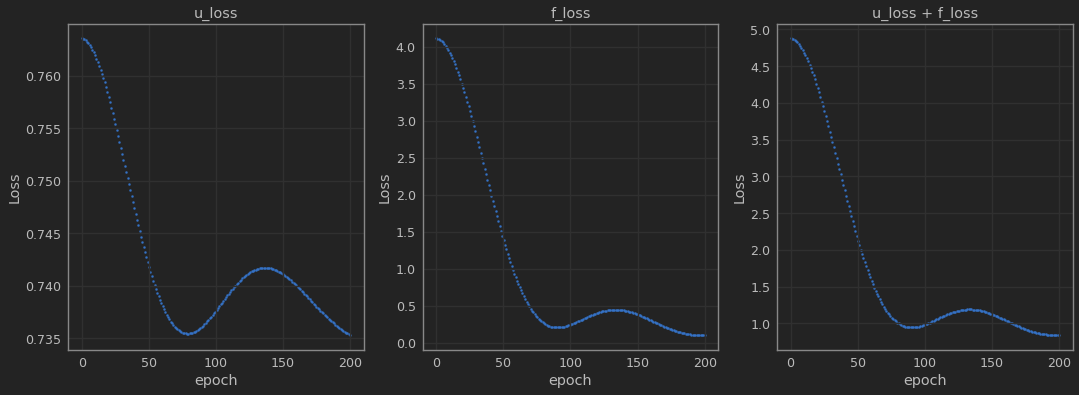

In [40]:
fig, axs = plt.subplots(1,3,figsize=(18,6))
# c_inference
epoch = np.linspace(0,loss.shape[0],loss.shape[0])

axs[0].set_title("u_loss")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("epoch")
axs[0].scatter(epoch[:],loss['u_loss'], s=5) 

axs[1].set_title("f_loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("epoch")
axs[1].scatter(epoch[:],loss['f_loss'], s=5) 

axs[2].set_title("u_loss + f_loss")
axs[2].set_ylabel("Loss")
axs[2].set_xlabel("epoch")
axs[2].scatter(epoch[:],loss['u_loss+f_loss'], s=5) 

plt.savefig("loss.png")


u_t tf.Tensor(
[[-9.1960939e-04]
 [ 3.2012563e-04]
 [ 5.4457213e-04]
 [ 7.6888746e-04]
 [-1.0476905e-03]
 [-8.3881721e-04]
 [ 3.9583718e-04]
 [ 3.8636691e-04]
 [-9.9471607e-04]
 [ 5.0764158e-04]
 [ 9.0994738e-04]
 [ 8.2028279e-04]
 [-1.0131579e-03]
 [ 3.0657032e-04]
 [-5.6945352e-04]
 [-1.0594274e-03]
 [ 8.2456076e-04]
 [-2.8758470e-04]
 [-4.7580476e-04]
 [-2.5279968e-04]
 [-6.7445356e-04]
 [-2.8732762e-04]
 [-5.9698621e-04]
 [-1.4368340e-04]
 [ 9.5509913e-06]
 [ 5.0155941e-04]
 [-2.6884009e-04]
 [-1.6787850e-04]
 [-8.6196035e-04]
 [ 4.7718565e-04]
 [ 3.6433991e-04]
 [ 1.4123569e-04]
 [-1.4789372e-04]
 [ 3.0358118e-04]
 [-1.3150346e-03]
 [-1.7334741e-04]
 [-9.1725611e-04]
 [-1.4022114e-03]
 [ 1.0703427e-04]
 [-1.3165366e-03]
 [ 6.4497808e-04]
 [-3.3089484e-04]
 [-1.3880981e-03]
 [ 4.6635291e-04]
 [ 2.4183515e-04]
 [-1.6418705e-04]
 [-8.7885535e-04]
 [ 1.3213768e-04]
 [-1.2205039e-03]
 [-8.7766000e-04]
 [ 8.5044070e-04]
 [ 2.5917304e-04]
 [ 6.9564203e-04]
 [-4.0157858e-04]
 [-7.6661457e

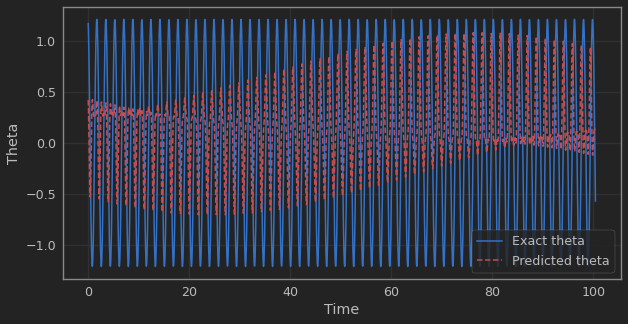

In [41]:
u_pred, f_pred = pinn.predict(X_star)
plt.figure(figsize=(10,5))
plt.plot(X_star[:,1],u_star, "b-", label = "Exact theta")
plt.plot(X_star[:,1],u_pred*10, "r--", label="Predicted theta")
plt.ylabel("Theta")
plt.xlabel("Time")
plt.legend()
plt.savefig("pred+exact.png")

In [23]:
results = np.vstack((u_star.T,np.array(u_pred*10).T))

No handles with labels found to put in legend.


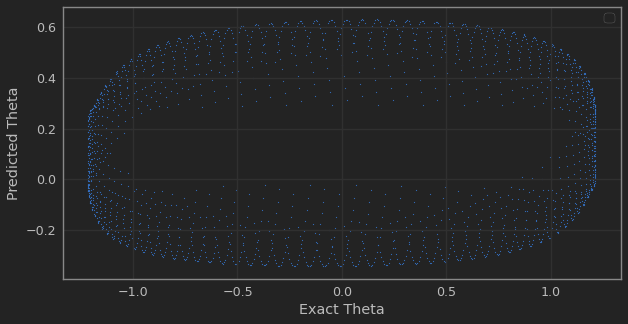

In [34]:
u_pred, f_pred = pinn.predict(X_star)
plt.figure(figsize=(10,5))
plt.scatter(results[0],results[1],s=1)
plt.ylabel("Predicted Theta")
plt.xlabel("Exact Theta")
plt.legend()
plt.savefig("pred_vs_exact.png")